# Learning to Reweight Examples for Robust Deep Learning


In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import math

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data as data

import math
import matplotlib.pyplot as plt

from argparse import Namespace

from fr_train import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
import pickle
import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import AdultDataset, GermanDataset, BankDataset, CompasDataset, BinaryLabelDataset, CelebADataset
from aif360.metrics import ClassificationMetric
import pandas

from sklearn.preprocessing import scale, StandardScaler, MaxAbsScaler
from tqdm import tqdm
import IPython

min_max_scaler = MaxAbsScaler()
std_scaler = StandardScaler()

In [2]:
np.random.seed(0)
#dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'bank': BankDataset(),'compas' : CompasDataset(),'celeb': CelebADataset()}
dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'bank': BankDataset(),'compas' : CompasDataset()}
dataset['german'].labels -= 1
sens_attr_dict = {'adult': ['sex', 'race'], 'german' : ['sex', 'age'], 'compas' : ['sex', 'race'], 'bank' : ['age'], 'celeb' : ['gender']}


In [4]:
data_name = 'adult'
protected_attribute_used = 1

In [5]:
if data_name == "adult":
    #dataset_orig = AdultDataset()
    # #dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        sens_attr = 'race'

elif data_name == "german":
    #dataset_orig = GermanDataset()
    # #dataset_orig.labels = #dataset_orig.labels-1
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'

elif data_name == "compas":
    #dataset_orig = CompasDataset()
    # #dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        sens_attr = 'race'

elif data_name == "bank":
    #dataset_orig = BankDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'
        
elif data_name == "meps":
    #dataset_orig = MEPSDataset19()
    privileged_groups = [{'RACE': 1}]
    unprivileged_groups = [{'RACE': 0}]
    sens_attr = 'RACE'

In [6]:
min_max_scaler = MaxAbsScaler()
std_scaler = StandardScaler()

In [7]:
sens_idx = dataset[data_name].feature_names.index(sens_attr)
num_sens = len(np.unique(dataset[data_name].features[:, sens_idx]))

#bs = 4000
workers = 16
device = 'cuda:2'
os.environ['CUDA_VISIBLE_DEVICES']='2'
hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}


feature_size = dataset[data_name].features.shape[1]
sens_loc = np.zeros(feature_size).astype(bool)
sens_loc[sens_idx] = 1

feature = dataset[data_name].features[:,~sens_loc] #data without sensitive
feature = min_max_scaler.fit_transform(feature)
# feature = std_scaler.fit_transform(feature)
dataset[data_name].features[:,~sens_loc] = feature

#self.sensitive = dataset[data_name].features[:,sens_loc].reshape(-1).astype(int)
#n_values = int(np.max(self.label) + 1)
#self.label = np.eye(n_values)[self.label.astype(int)].squeeze(1)
# dataset[data_name], _ = dataset[data_name].split([0.5], shuffle=True)
data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
data_valid, data_test = data_vt.split([0.5], shuffle=True)

In [8]:
sens_attr

'sex'

In [9]:
class Dataset(data.Dataset):
    def __init__(self, dataset, sens_idx):
        self.label = dataset.labels.squeeze(-1).astype(int)
        
        self.feature_size = dataset.features.shape[1]
        sens_loc = np.zeros(self.feature_size).astype(bool)
        sens_loc[sens_idx] = 1

        self.feature = dataset.features[:,~sens_loc] #data without sensitive
#         self.feature = min_max_scaler.fit_transform(self.feature)
        
        self.sensitive = dataset.features[:,sens_loc].reshape(-1).astype(int)
        #n_values = int(np.max(self.label) + 1)
        #self.label = np.eye(n_values)[self.label.astype(int)].squeeze(1)
        
    def __getitem__(self, idx):
    
        y = self.label[idx]
        x = self.feature[idx]
        a = self.sensitive[idx]
        
        return x, a, y
    
    
    def __len__(self):
        return len(self.label)
    

In [14]:
class Net(MetaModule):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self, input_size, latent_size):
        """Initializes Generator with torch components."""
        
        super(Net, self).__init__()

    
        def block(in_feat, out_feat, normalize=True):
            """Defines a block with torch components.
            
                Args:
                    in_feat: An integer value for the size of the input feature.
                    out_feat: An integer value for the size of the output feature.
                    normalize: A boolean indicating whether normalization is needed.
                    
                Returns:
                    The stacked layer.
            """
            
            layers = [MetaLinear(in_feat, out_feat)]
            if normalize:
                layers.append(MetaBatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(input_size, latent_size, normalize=True),
            *block(latent_size, latent_size, normalize=True),
            *block(latent_size, latent_size, normalize=True),
#             nn.Linear(32, 1),
#             nn.Tanh()
            MetaLinear(latent_size,1),
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output
            
            
def build_model(input_size, latent_size):
    net = Net(input_size, latent_size)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [13]:
def train_LWE(results_dict):
    net = Net(input_size, latent_size)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.Adam(net.params(),lr=lr)

    meta_losses_clean = []
    net_losses = []
    plot_step = 20

    smoothing_alpha = 0.9

    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(epochs):
        net.train()
        # Line 2 get batch of data
        image, sens, labels = next(iter(trainloader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = Net(input_size, latent_size)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False).float()
        labels = to_var(labels, requires_grad=False).float().view(-1,1)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()

        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(lr, source_params=grads)

        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        val_data, sens_val, val_labels = iter(validloader).next()
        val_data = to_var(val_data, requires_grad=False).float()
        val_labels = to_var(val_labels, requires_grad=False).float().view(-1,1)

        y_g_hat = meta_net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]

        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_sens, test_label) in enumerate(testloader):
                test_img = to_var(test_img, requires_grad=False).float()
                test_label = to_var(test_label, requires_grad=False).float().view(-1,1)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])

            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()

    tp_priv, tn_priv, fp_priv, fn_priv, \
    tp_unpriv, tn_unpriv, fp_unpriv, fn_unpriv = 0, 0, 0, 0, 0, 0, 0, 0

    for x_val, a_val, y_val in testloader:
        x_val, a_val, y_val = x_val.cuda().float(), a_val.cuda().float(), y_val.cuda().float()

        priv_idx = (a_val==1).squeeze()
        positive_idx = y_val==1

        pred_test = net(x_val)

        test_lb_priv = y_val[priv_idx]
        test_lb_unpriv = y_val[~priv_idx]

        pred_priv = net(x_val[priv_idx])
        pred_unpriv = net(x_val[~priv_idx])

        y_val = y_val.cpu().detach().numpy()
        test_lb_priv = test_lb_priv.cpu().detach().numpy()
        test_lb_unpriv = test_lb_unpriv.cpu().detach().numpy()

        pred_priv[pred_priv>=0] = 1
        pred_priv[pred_priv<0] = 0

        pred_unpriv[pred_unpriv>=0] = 1
        pred_unpriv[pred_unpriv<0] = 0


        tp_priv += sum(pred_priv[test_lb_priv == 1] == 1)
        fp_priv += sum(pred_priv[test_lb_priv == 0] == 1)
        tn_priv += sum(pred_priv[test_lb_priv == 0] == 0)
        fn_priv += sum(pred_priv[test_lb_priv == 1] == 0)

        tp_unpriv += sum(pred_unpriv[test_lb_unpriv == 1] == 1)
        fp_unpriv += sum(pred_unpriv[test_lb_unpriv == 0] == 1)
        tn_unpriv += sum(pred_unpriv[test_lb_unpriv == 0] == 0)
        fn_unpriv += sum(pred_unpriv[test_lb_unpriv == 1] == 0)

    tpr_overall = (tp_priv + tp_unpriv)/(tp_priv + tp_unpriv + fn_priv + fn_unpriv).float().item()
    tpr_priv = (tp_unpriv)/(tp_unpriv + fn_unpriv).float().item()
    tpr_unpriv = (tp_priv)/(tp_priv + fn_priv).float().item()

    fpr_overall = (fp_priv + fp_unpriv)/(tn_priv + tn_unpriv + fp_priv + fp_unpriv).float().item()
    fpr_unpriv = (fp_unpriv)/(tn_unpriv + fp_unpriv).float().item()
    fpr_priv = (fp_priv)/(tn_priv + fp_priv).float().item()

    acc_overall = (tp_priv + tn_priv + tp_unpriv + tn_unpriv)/(tp_priv + tn_priv + tp_unpriv + tn_unpriv + \
                                                              fp_priv + fn_priv + fp_unpriv + fn_unpriv).float().item()
    acc_priv = (tp_priv + tn_priv)/(tp_priv + tn_priv + fp_priv + fn_priv).float().item()
    acc_unpriv = (tp_unpriv + tn_unpriv)/(tp_unpriv + tn_unpriv + fp_unpriv + fn_unpriv).float().item()


    print()
    print('overall TPR : {0:.3f}'.format( tpr_overall.item()))
    print('priv TPR : {0:.3f}'.format( tpr_priv.item()))
    print('unpriv TPR : {0:.3f}'.format( tpr_unpriv.item()))
    print('Eq. Opp : {0:.3f}'.format( abs(tpr_unpriv - tpr_priv).item()))
    print()
    print('overall FPR : {0:.3f}'.format( fpr_overall.item()))
    print('priv FPR : {0:.3f}'.format( fpr_priv.item()))
    print('unpriv FPR : {0:.3f}'.format( fpr_unpriv.item()))
    print('diff FPR : {0:.3f}'.format( abs(fpr_unpriv-fpr_priv).item()))
    print()
    print('overall ACC : {0:.3f}'.format( acc_overall.item()))
    print('priv ACC : {0:.3f}'.format( acc_priv.item()))
    print('unpriv ACC : {0:.3f}'.format( acc_unpriv.item())) 
    print('diff ACC : {0:.3f}\n\n\n'.format( abs(acc_unpriv-acc_priv).item()))

    valid_pred = data_valid.copy(deepcopy=True)
    feature_size = valid_pred.features.shape[1]
    sens_loc = np.zeros(feature_size).astype(bool)
    sens_loc[sens_idx] = 1

    feature = valid_pred.features[:,~sens_loc] #data without sensitive
    feature = min_max_scaler.fit_transform(feature)

    valid_pred.labels = (net(torch.tensor(feature).cuda().float())).argmax(-1).cpu().numpy().reshape(-1,1)

    classified_metric = ClassificationMetric(data_valid,
                                                     valid_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)


    print('balanced acc :' ,1/2*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate()))
    print('disparate_impact :' ,classified_metric.disparate_impact())
    print('theil_index :' ,classified_metric.theil_index())
    print('statistical_parity_difference :' ,classified_metric.statistical_parity_difference())
    print('generalized_entropy_index : ', classified_metric.generalized_entropy_index())

    results_dict[poi_ratio]['EqOdds'].append(abs(fpr_unpriv-fpr_priv) + abs(tpr_unpriv - tpr_priv))
    results_dict[poi_ratio]['Acc'].append( acc_overall)
    results_dict[poi_ratio]['DISP'].append( classified_metric.disparate_impact())
    results_dict[poi_ratio]['EqOpp'].append( abs(tpr_unpriv - tpr_priv))
    results_dict[poi_ratio]['Acc_diff'].append( abs(acc_unpriv-acc_priv))

    results_dict[poi_ratio]['total_tpr'].append(tpr_overall)
    results_dict[poi_ratio]['total_fpr'].append(fpr_overall)

    results_dict[poi_ratio]['total_tpr_priv'].append(tpr_priv)
    results_dict[poi_ratio]['total_tpr_unpriv'].append(tpr_unpriv)
    results_dict[poi_ratio]['total_fpr_priv'].append(fpr_priv)
    results_dict[poi_ratio]['total_fpr_unpriv'].append(fpr_unpriv)

# return accuracy
# return np.mean(acc_log[-6:-1, 1])

In [112]:
results_dict

{0.1: {'EqOdds': [tensor([0.1583], device='cuda:0')],
  'Acc': [tensor([0.7133], device='cuda:0')],
  'DISP': [nan],
  'EqOpp': [tensor([0.0819], device='cuda:0')],
  'Acc_diff': [tensor([0.0400], device='cuda:0')],
  'total_tpr': [tensor([0.4783], device='cuda:0')],
  'total_fpr': [tensor([0.1827], device='cuda:0')],
  'total_tpr_priv': [tensor([0.5263], device='cuda:0')],
  'total_tpr_unpriv': [tensor([0.4444], device='cuda:0')],
  'total_fpr_priv': [tensor([0.2055], device='cuda:0')],
  'total_fpr_unpriv': [tensor([0.1290], device='cuda:0')]},
 0.2: {'EqOdds': [tensor([0.2286], device='cuda:0')],
  'Acc': [tensor([0.7600], device='cuda:0')],
  'DISP': [nan],
  'EqOpp': [tensor([0.0484], device='cuda:0')],
  'Acc_diff': [tensor([0.1373], device='cuda:0')],
  'total_tpr': [tensor([0.5333], device='cuda:0')],
  'total_fpr': [tensor([0.1429], device='cuda:0')],
  'total_tpr_priv': [tensor([0.5000], device='cuda:0')],
  'total_tpr_unpriv': [tensor([0.5484], device='cuda:0')],
  'total_fp

In [16]:
input_size = dataset[data_name].features.shape[-1] - 1
latent_size = 512
hidden_size = 512

lr = 1e-3

poi ratio: 0.1


 19%|█▉        | 19/100 [00:29<02:03,  1.53s/it]

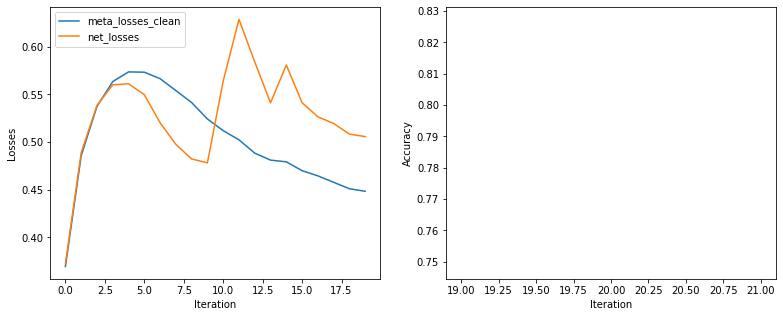

 39%|███▉      | 39/100 [01:01<01:34,  1.55s/it]

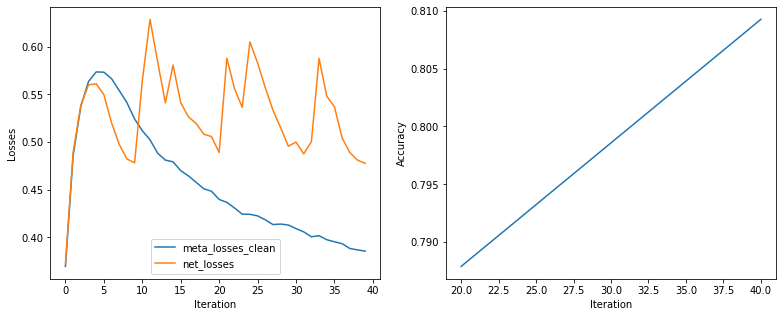

 59%|█████▉    | 59/100 [01:32<01:02,  1.53s/it]

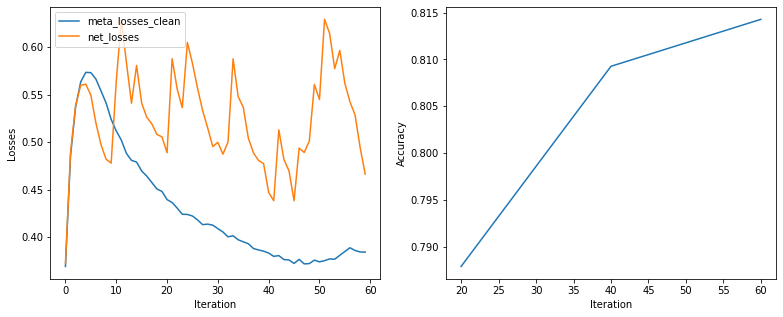

 79%|███████▉  | 79/100 [02:04<00:32,  1.52s/it]

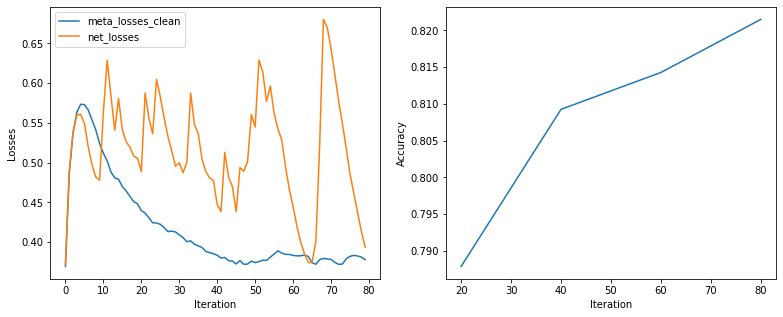

 86%|████████▌ | 86/100 [02:15<00:21,  1.52s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-72plg_7v'
 99%|█████████▉| 99/100 [02:35<00:01,  1.47s/it]

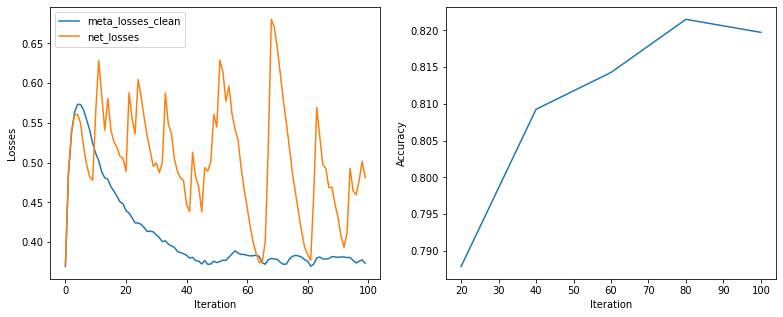

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.628
priv TPR : 0.504
unpriv TPR : 0.648
Eq. Opp : 0.144

overall FPR : 0.116
priv FPR : 0.159
unpriv FPR : 0.045
diff FPR : 0.114

overall ACC : 0.820
priv ACC : 0.780
unpriv ACC : 0.905
diff ACC : 0.126



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28067927700687717
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16201444466133108


 19%|█▉        | 19/100 [00:29<02:04,  1.54s/it]

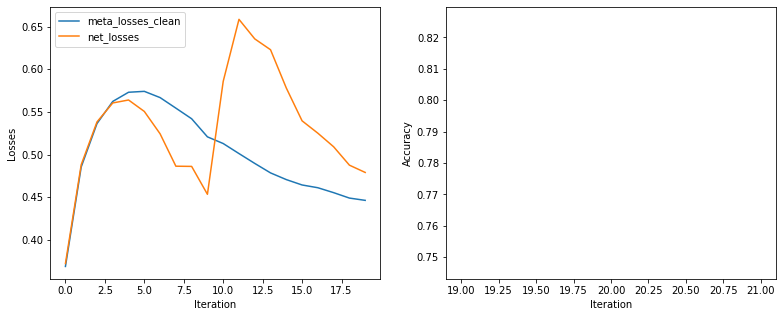

 39%|███▉      | 39/100 [01:01<01:34,  1.54s/it]

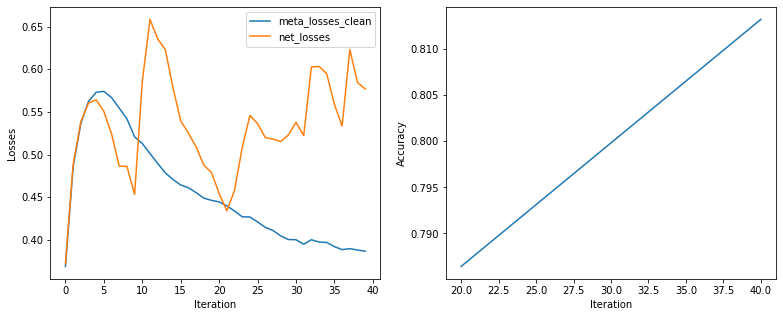

 59%|█████▉    | 59/100 [01:33<01:03,  1.56s/it]

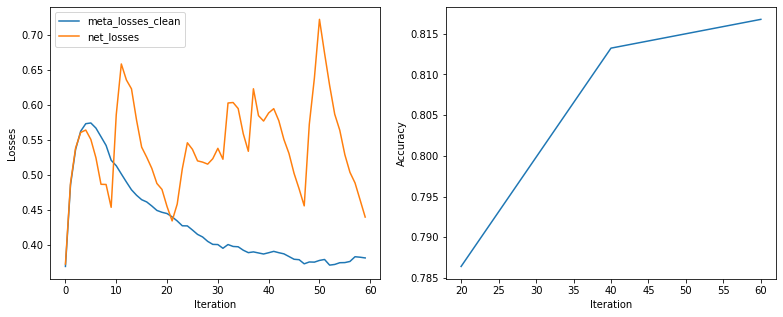

 79%|███████▉  | 79/100 [02:05<00:32,  1.54s/it]

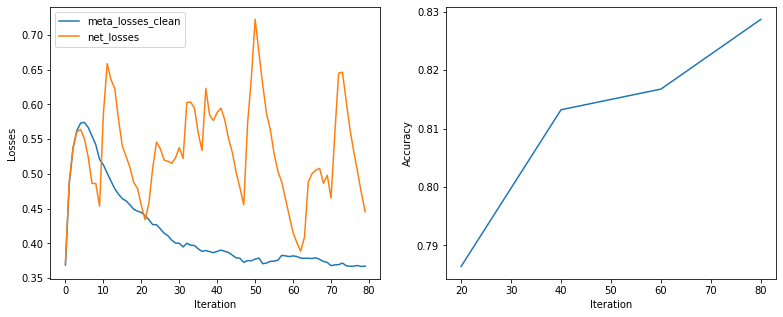

 99%|█████████▉| 99/100 [02:37<00:01,  1.60s/it]

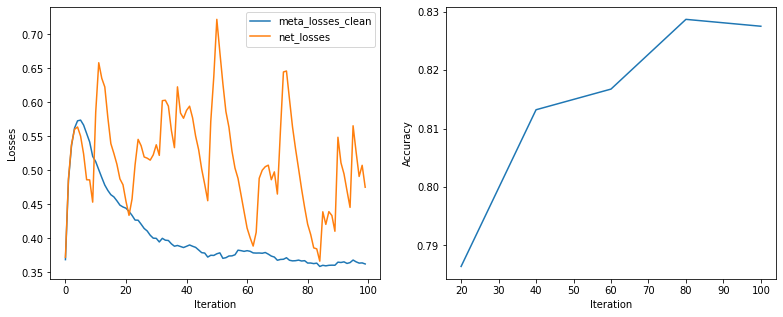

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.613
priv TPR : 0.415
unpriv TPR : 0.652
Eq. Opp : 0.237

overall FPR : 0.102
priv FPR : 0.152
unpriv FPR : 0.024
diff FPR : 0.128

overall ACC : 0.828
priv ACC : 0.788
unpriv ACC : 0.907
diff ACC : 0.119



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28165574422634526
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16266119577960134


 19%|█▉        | 19/100 [00:30<02:15,  1.67s/it]

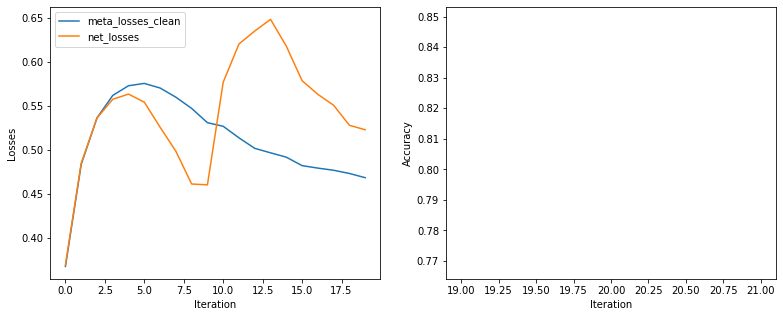

 39%|███▉      | 39/100 [01:04<01:39,  1.63s/it]

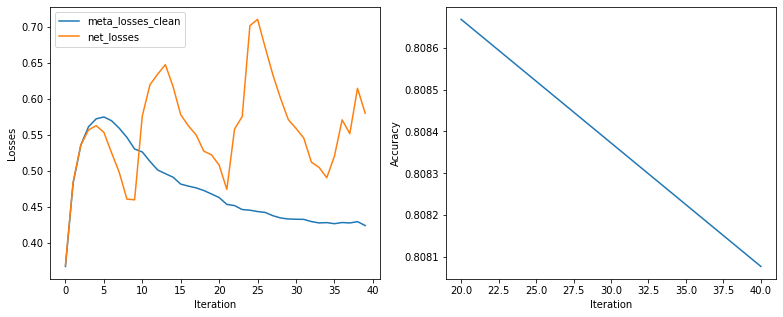

 58%|█████▊    | 58/100 [01:36<01:08,  1.62s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-yhmwzbdp'
 59%|█████▉    | 59/100 [01:38<01:06,  1.62s/it]

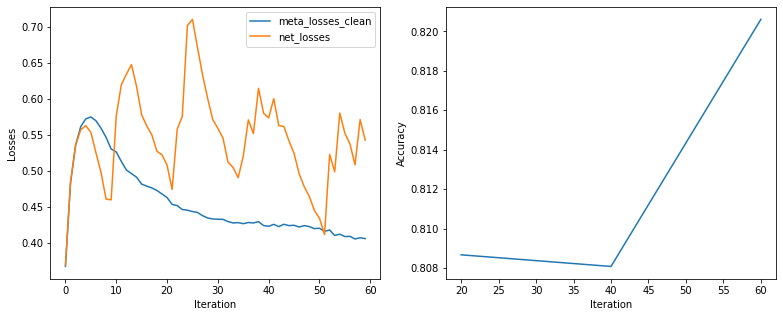

 79%|███████▉  | 79/100 [02:11<00:34,  1.63s/it]

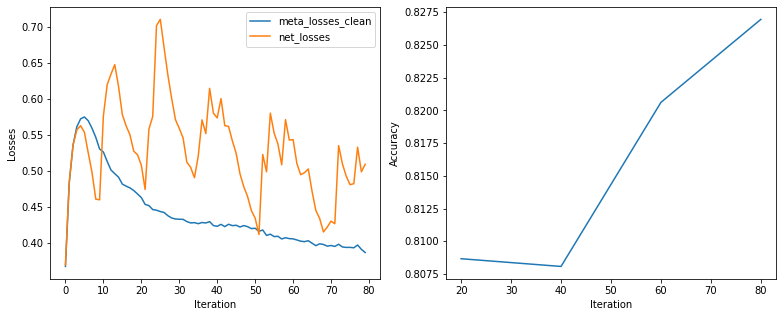

 99%|█████████▉| 99/100 [02:44<00:01,  1.62s/it]

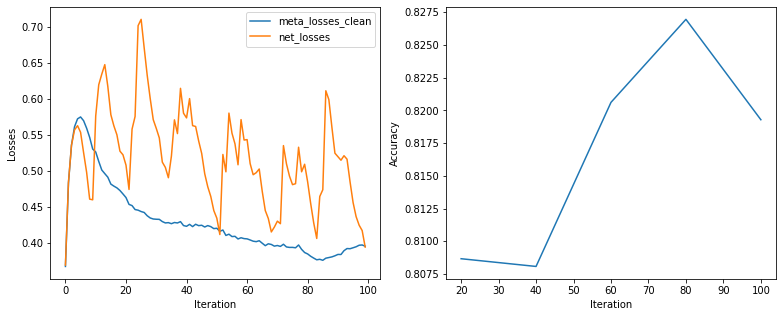

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.682
priv TPR : 0.556
unpriv TPR : 0.705
Eq. Opp : 0.149

overall FPR : 0.136
priv FPR : 0.189
unpriv FPR : 0.054
diff FPR : 0.135

overall ACC : 0.819
priv ACC : 0.778
unpriv ACC : 0.903
diff ACC : 0.125



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2875346559261214
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16656839622641503


 19%|█▉        | 19/100 [00:31<02:16,  1.69s/it]

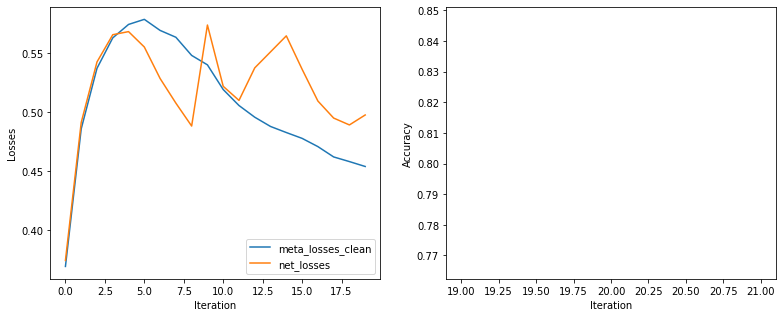

 39%|███▉      | 39/100 [01:05<01:41,  1.66s/it]

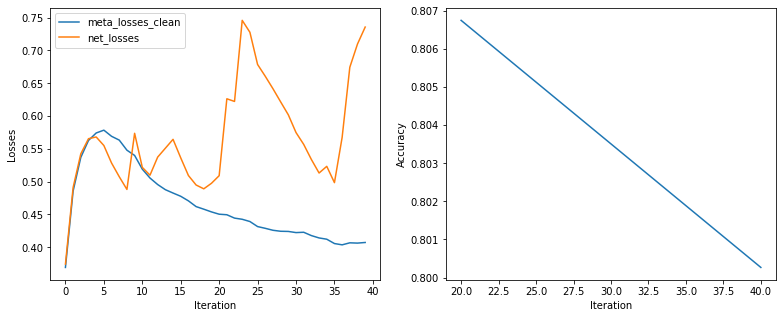

 59%|█████▉    | 59/100 [01:40<01:07,  1.65s/it]

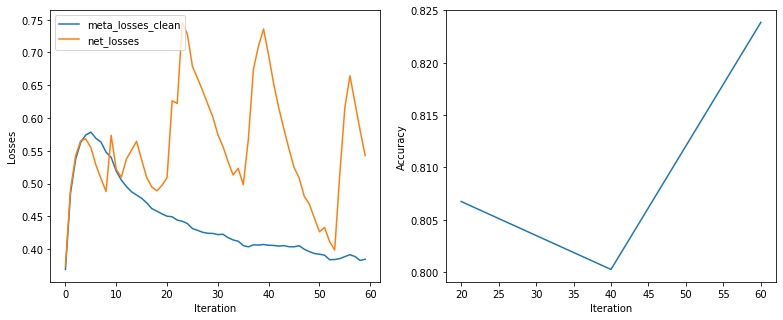

 79%|███████▉  | 79/100 [02:14<00:34,  1.65s/it]

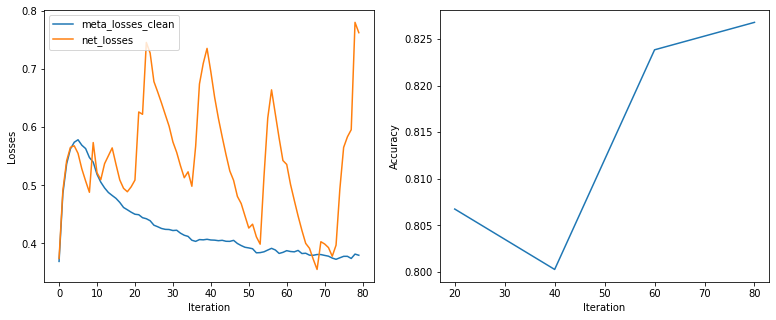

 99%|█████████▉| 99/100 [02:48<00:01,  1.64s/it]

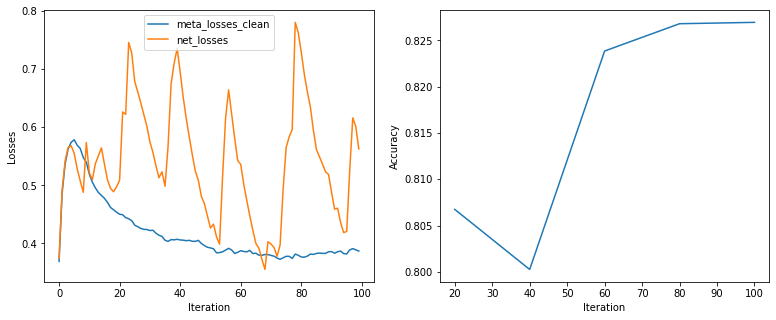

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.614
priv TPR : 0.565
unpriv TPR : 0.622
Eq. Opp : 0.058

overall FPR : 0.103
priv FPR : 0.138
unpriv FPR : 0.049
diff FPR : 0.089

overall ACC : 0.827
priv ACC : 0.786
unpriv ACC : 0.909
diff ACC : 0.122



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.27464636973376927
statistical_parity_difference : 0.0
generalized_entropy_index :  0.15803259604190928


 19%|█▉        | 19/100 [00:31<02:15,  1.68s/it]

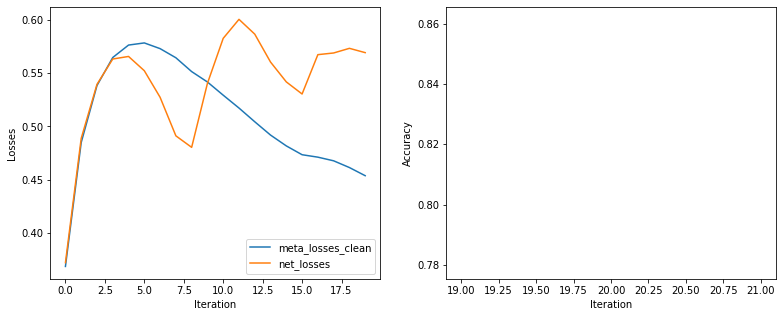

 22%|██▏       | 22/100 [00:38<02:24,  1.85s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-qvy3ga32'
 23%|██▎       | 23/100 [00:39<02:19,  1.81s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*sel

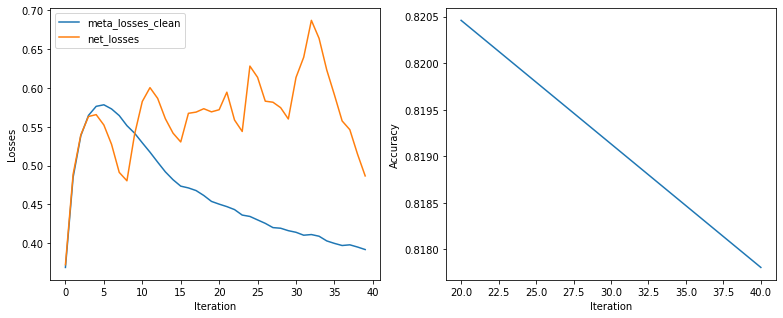

 59%|█████▉    | 59/100 [01:41<01:08,  1.68s/it]

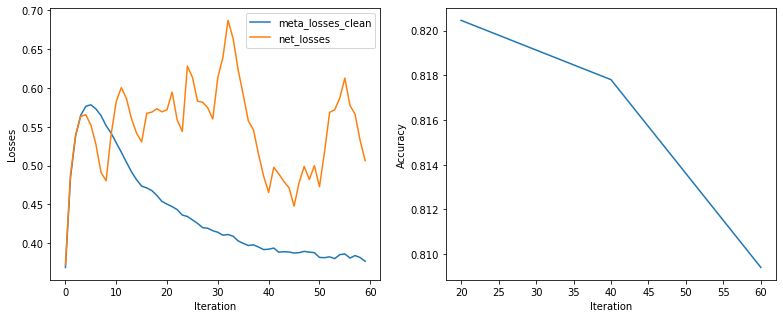

 79%|███████▉  | 79/100 [02:16<00:36,  1.72s/it]

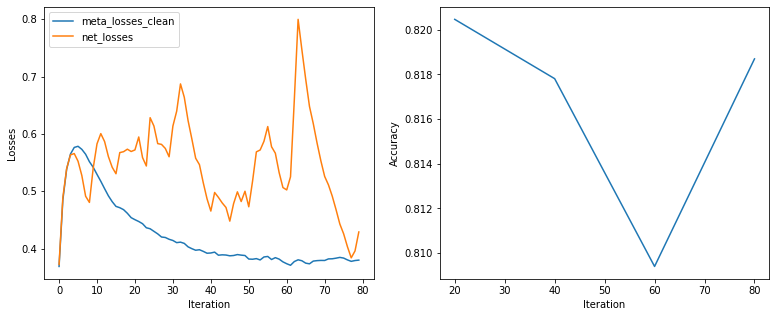

 99%|█████████▉| 99/100 [02:51<00:01,  1.70s/it]

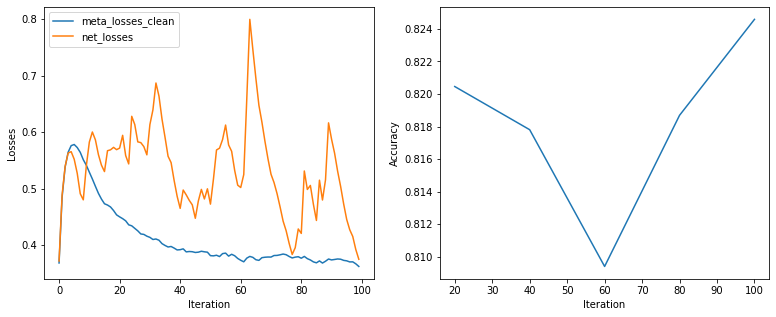

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.624
priv TPR : 0.476
unpriv TPR : 0.650
Eq. Opp : 0.174

overall FPR : 0.108
priv FPR : 0.153
unpriv FPR : 0.031
diff FPR : 0.122

overall ACC : 0.825
priv ACC : 0.785
unpriv ACC : 0.912
diff ACC : 0.127



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.27872919838577626
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1607247223845703
poi ratio: 0.2


 19%|█▉        | 19/100 [00:32<02:18,  1.71s/it]

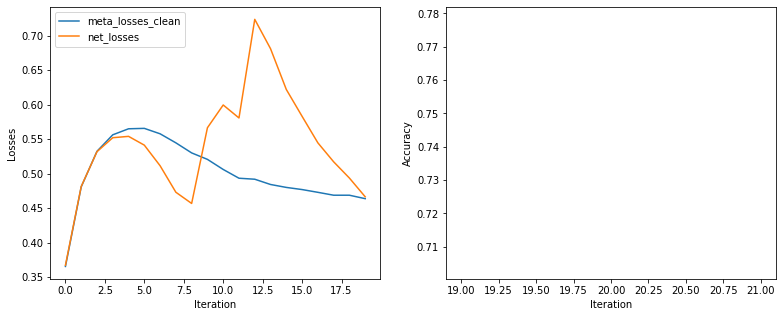

 39%|███▉      | 39/100 [01:08<01:45,  1.72s/it]

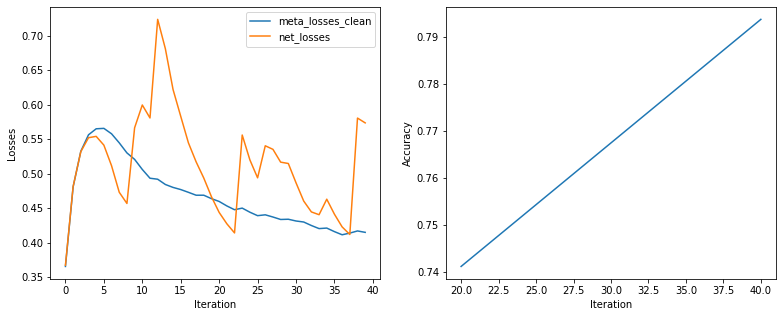

 59%|█████▉    | 59/100 [01:43<01:10,  1.73s/it]

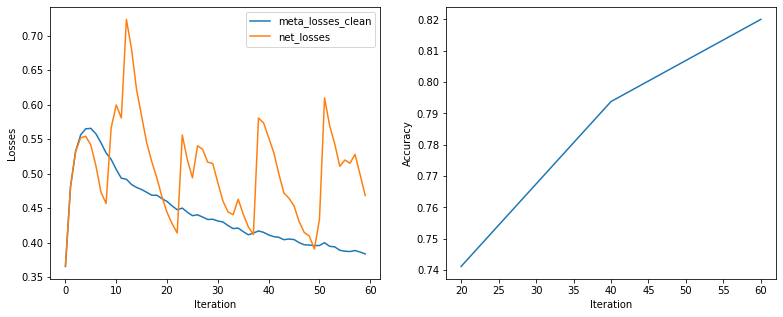

 79%|███████▉  | 79/100 [02:19<00:36,  1.74s/it]

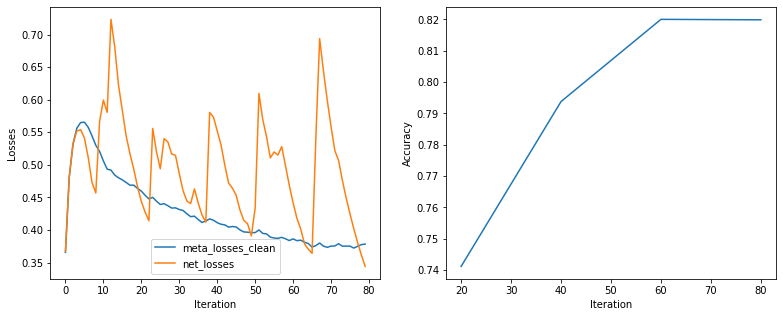

 81%|████████  | 81/100 [02:23<00:37,  1.96s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-tpq2hljz'
 99%|█████████▉| 99/100 [02:55<00:01,  1.71s/it]

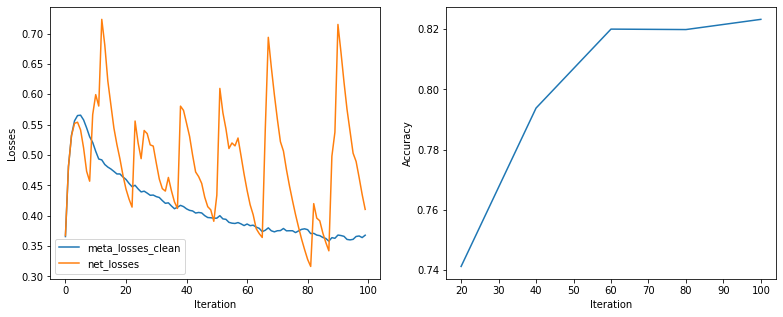

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.546
priv TPR : 0.359
unpriv TPR : 0.577
Eq. Opp : 0.218

overall FPR : 0.085
priv FPR : 0.127
unpriv FPR : 0.018
diff FPR : 0.109

overall ACC : 0.823
priv ACC : 0.780
unpriv ACC : 0.914
diff ACC : 0.134



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28537503989092367
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16513041772896642


 19%|█▉        | 19/100 [00:33<02:20,  1.74s/it]

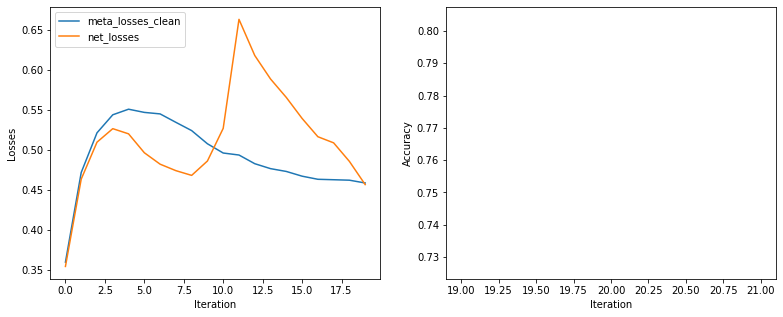

 37%|███▋      | 37/100 [01:05<01:50,  1.76s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-uh6kba6i'
 39%|███▉      | 39/100 [01:09<01:45,  1.74s/it]

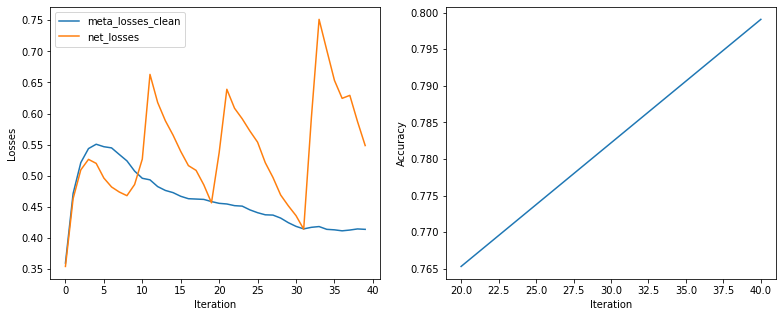

 59%|█████▉    | 59/100 [01:45<01:11,  1.75s/it]

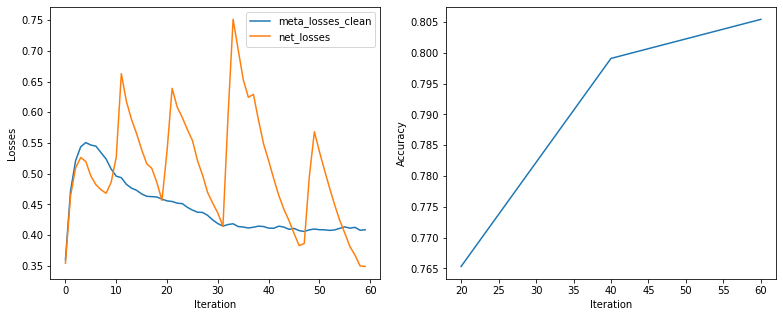

 79%|███████▉  | 79/100 [02:21<00:36,  1.76s/it]

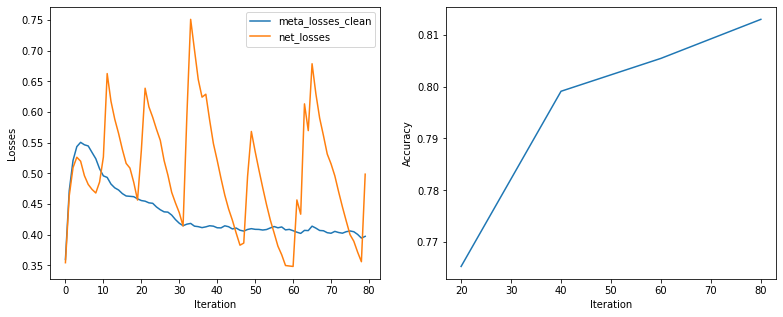

 99%|█████████▉| 99/100 [02:57<00:01,  1.75s/it]

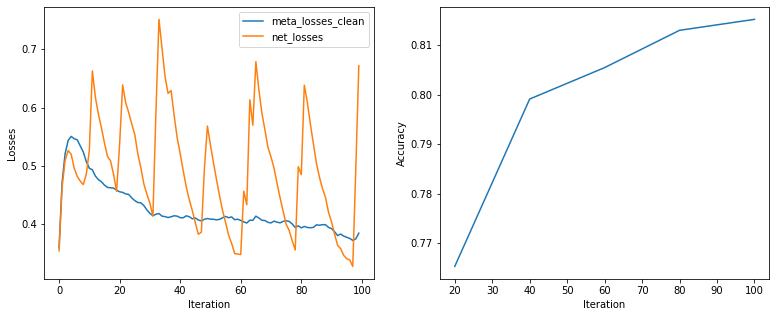

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.617
priv TPR : 0.457
unpriv TPR : 0.645
Eq. Opp : 0.187

overall FPR : 0.117
priv FPR : 0.172
unpriv FPR : 0.029
diff FPR : 0.142

overall ACC : 0.815
priv ACC : 0.770
unpriv ACC : 0.910
diff ACC : 0.140



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28243760509494775
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16317950723504124


 19%|█▉        | 19/100 [00:33<02:19,  1.73s/it]

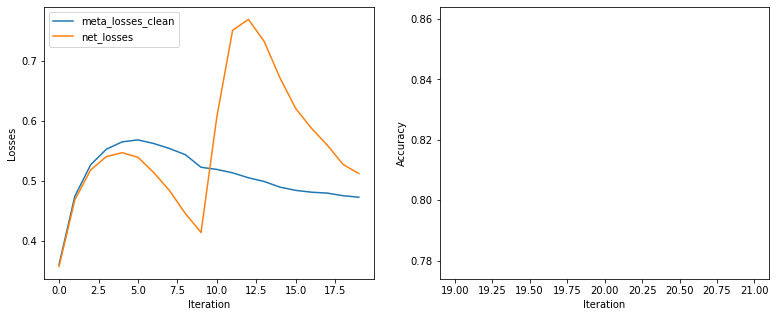

 39%|███▉      | 39/100 [01:08<01:45,  1.73s/it]

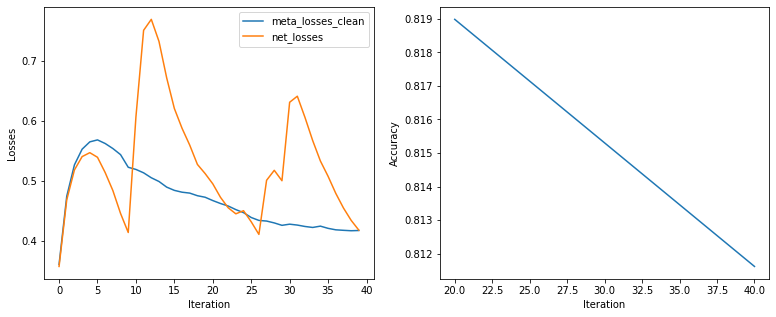

 59%|█████▉    | 59/100 [01:44<01:11,  1.74s/it]

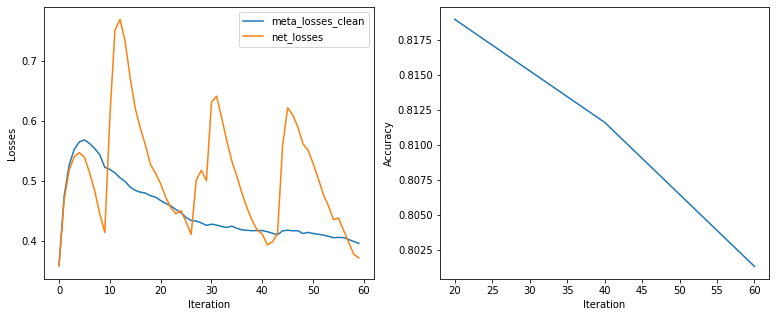

 79%|███████▉  | 79/100 [02:20<00:36,  1.72s/it]

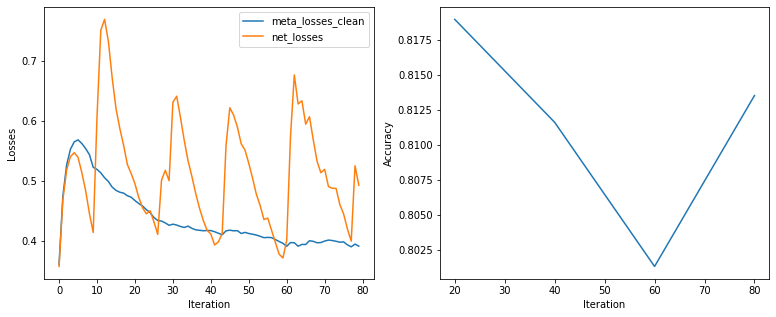

 99%|█████████▉| 99/100 [02:56<00:01,  1.74s/it]

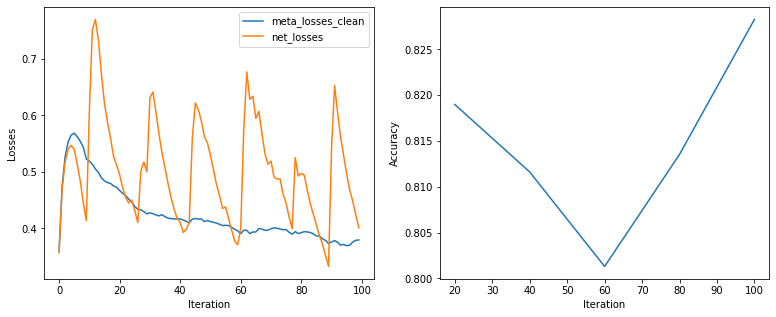

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.621
priv TPR : 0.470
unpriv TPR : 0.643
Eq. Opp : 0.173

overall FPR : 0.103
priv FPR : 0.151
unpriv FPR : 0.025
diff FPR : 0.127

overall ACC : 0.828
priv ACC : 0.783
unpriv ACC : 0.925
diff ACC : 0.142



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2896989459986853
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16801260586960817


 19%|█▉        | 19/100 [00:33<02:23,  1.77s/it]

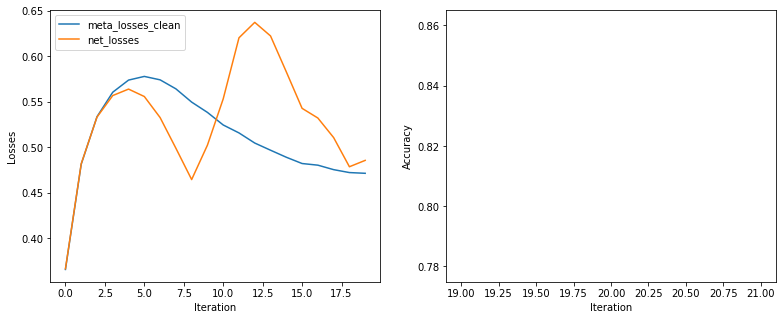

 39%|███▉      | 39/100 [01:10<01:48,  1.78s/it]

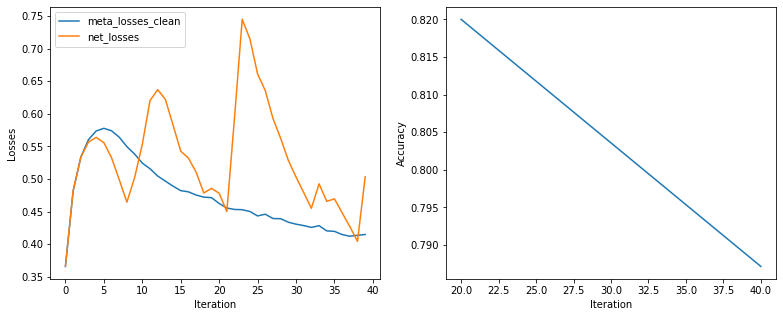

 59%|█████▉    | 59/100 [01:46<01:12,  1.76s/it]

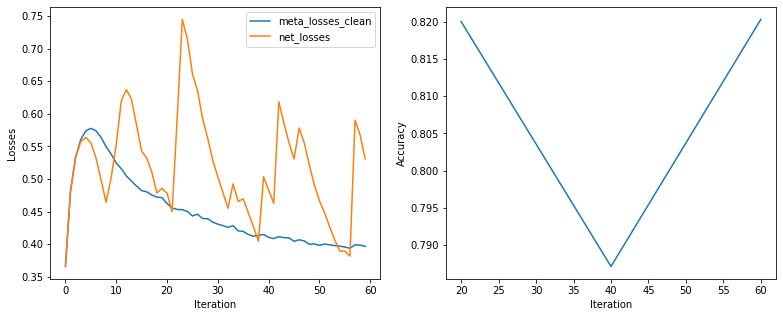

 79%|███████▉  | 79/100 [02:23<00:37,  1.78s/it]

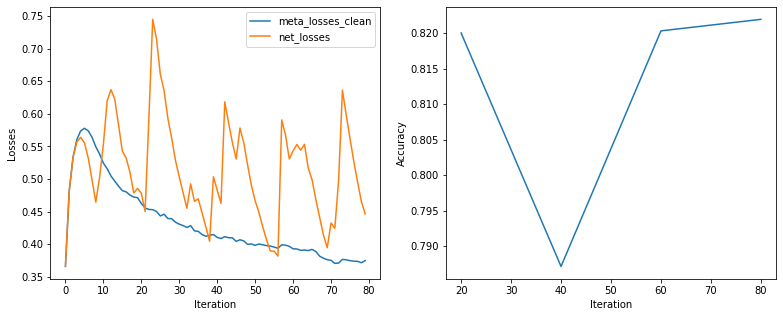

 99%|█████████▉| 99/100 [02:59<00:01,  1.76s/it]

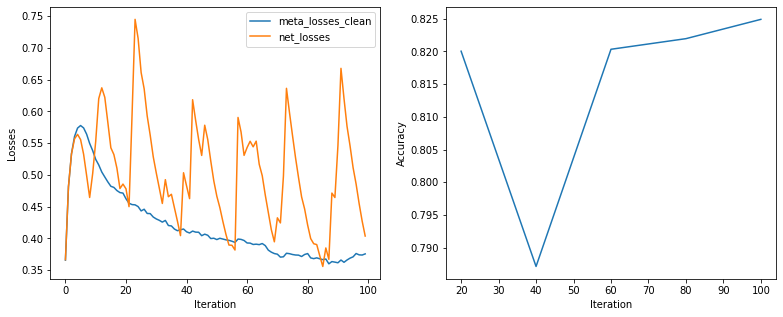

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.591
priv TPR : 0.433
unpriv TPR : 0.615
Eq. Opp : 0.183

overall FPR : 0.101
priv FPR : 0.140
unpriv FPR : 0.037
diff FPR : 0.103

overall ACC : 0.825
priv ACC : 0.786
unpriv ACC : 0.910
diff ACC : 0.124



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.27561696089993837
statistical_parity_difference : 0.0
generalized_entropy_index :  0.15867158671586734


 19%|█▉        | 19/100 [00:34<02:27,  1.82s/it]

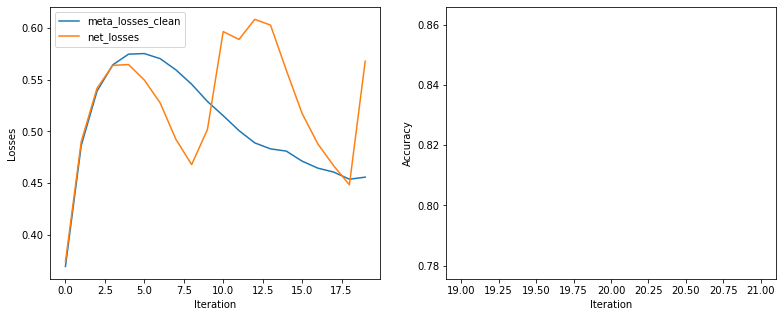

 39%|███▉      | 39/100 [01:11<01:51,  1.82s/it]

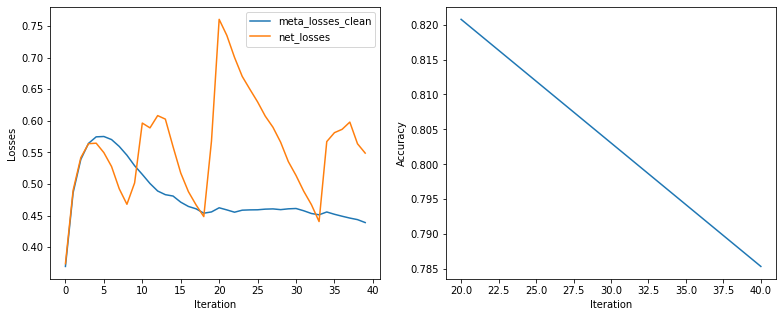

 59%|█████▉    | 59/100 [01:48<01:15,  1.83s/it]

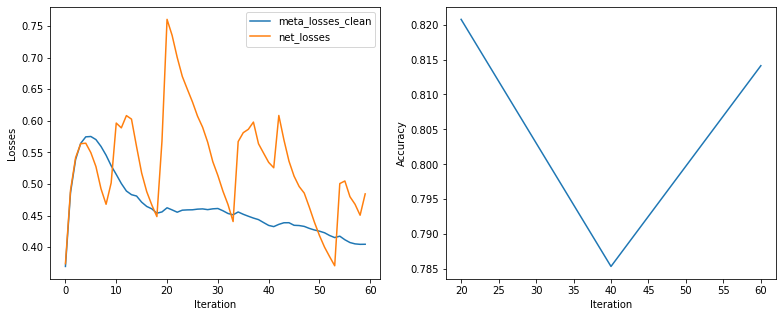

 79%|███████▉  | 79/100 [02:26<00:38,  1.83s/it]

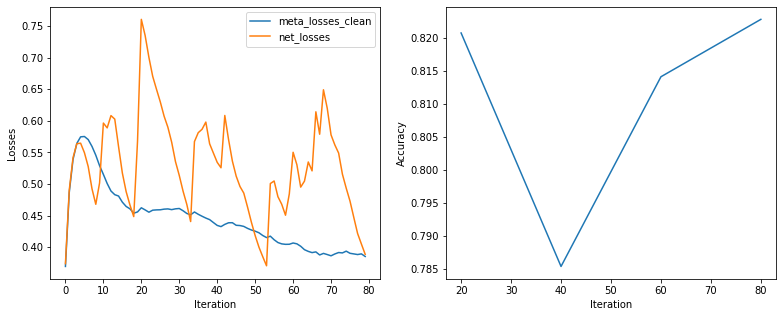

 99%|█████████▉| 99/100 [03:04<00:01,  1.85s/it]

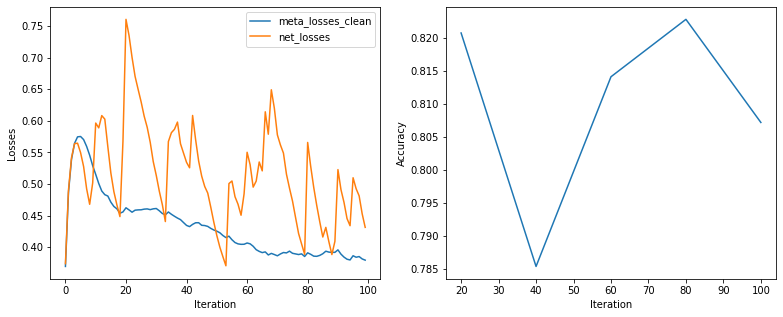

100%|██████████| 100/100 [03:07<00:00,  1.88s/it]



overall TPR : 0.649
priv TPR : 0.536
unpriv TPR : 0.668
Eq. Opp : 0.132

overall FPR : 0.143
priv FPR : 0.183
unpriv FPR : 0.079
diff FPR : 0.104

overall ACC : 0.807
priv ACC : 0.771
unpriv ACC : 0.880
diff ACC : 0.109



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28832112863673487
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16709284028324153
poi ratio: 0.30000000000000004


 19%|█▉        | 19/100 [00:35<02:29,  1.84s/it]

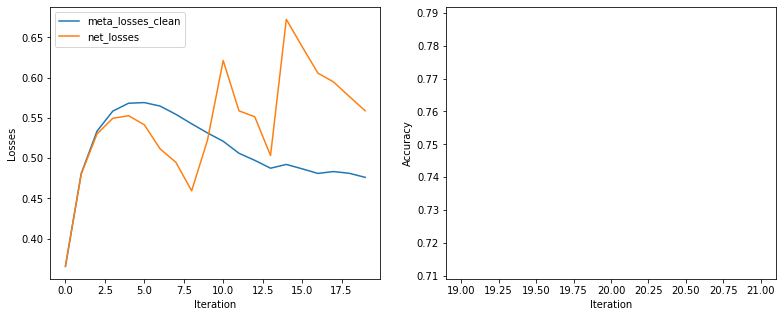

 39%|███▉      | 39/100 [01:13<01:52,  1.85s/it]

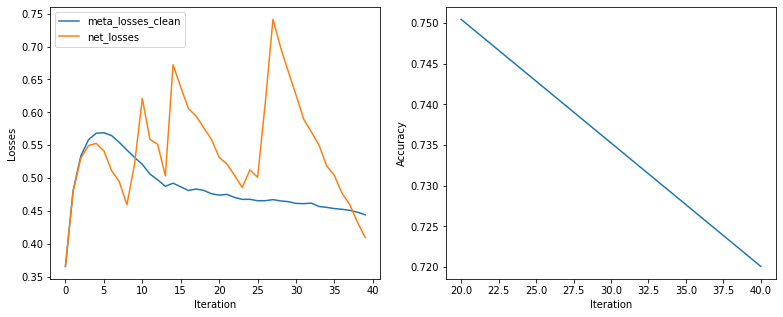

 59%|█████▉    | 59/100 [01:51<01:15,  1.84s/it]

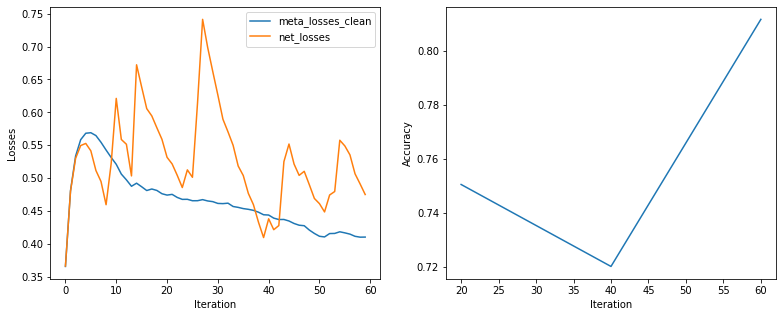

 79%|███████▉  | 79/100 [02:29<00:38,  1.86s/it]

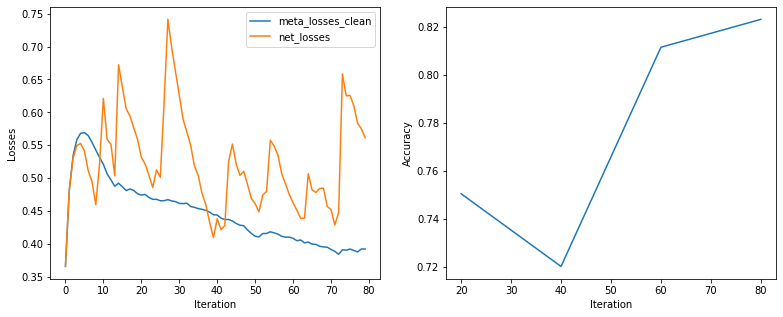

 99%|█████████▉| 99/100 [03:08<00:01,  1.85s/it]

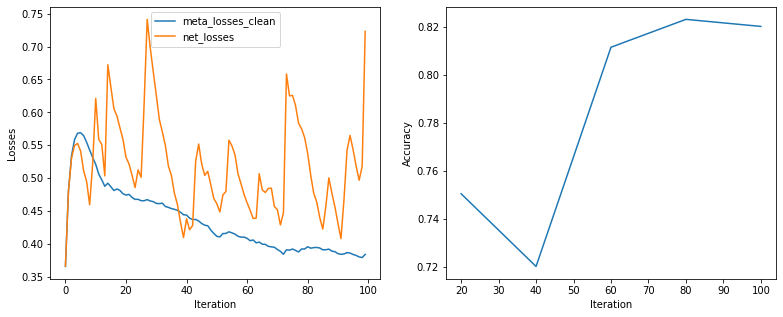

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.565
priv TPR : 0.366
unpriv TPR : 0.601
Eq. Opp : 0.235

overall FPR : 0.095
priv FPR : 0.143
unpriv FPR : 0.019
diff FPR : 0.124

overall ACC : 0.820
priv ACC : 0.776
unpriv ACC : 0.910
diff ACC : 0.134



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2849828830231529
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16486963340521468


 19%|█▉        | 19/100 [00:36<02:37,  1.94s/it]

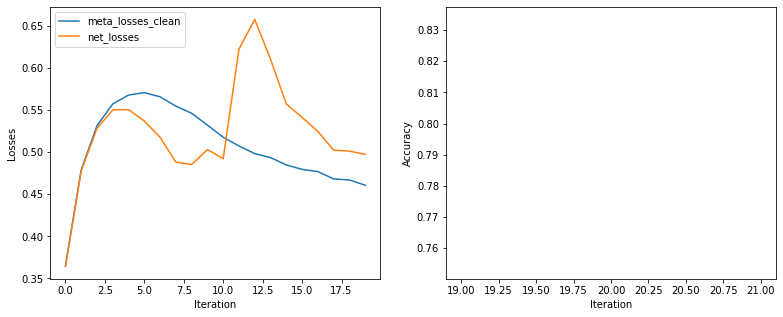

 39%|███▉      | 39/100 [01:15<01:55,  1.89s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-p06lnxtk'


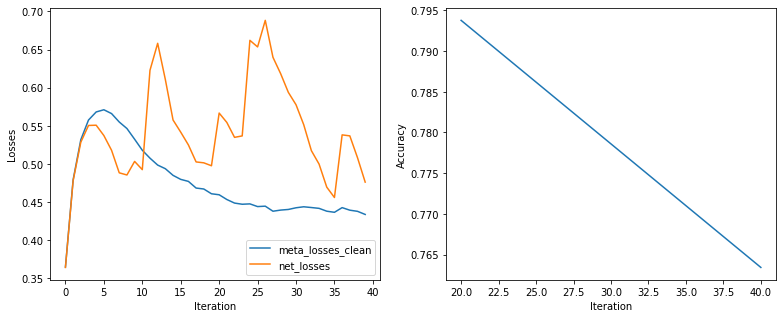

 59%|█████▉    | 59/100 [01:53<01:16,  1.87s/it]

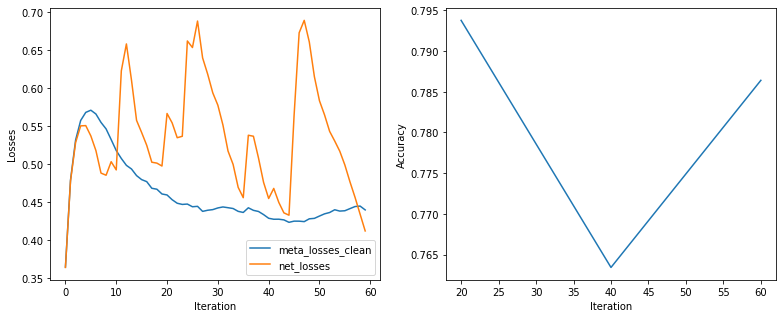

 79%|███████▉  | 79/100 [02:33<00:39,  1.90s/it]

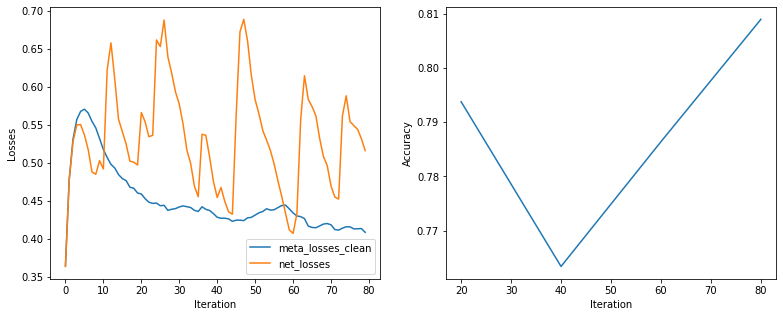

 99%|█████████▉| 99/100 [03:11<00:01,  1.90s/it]

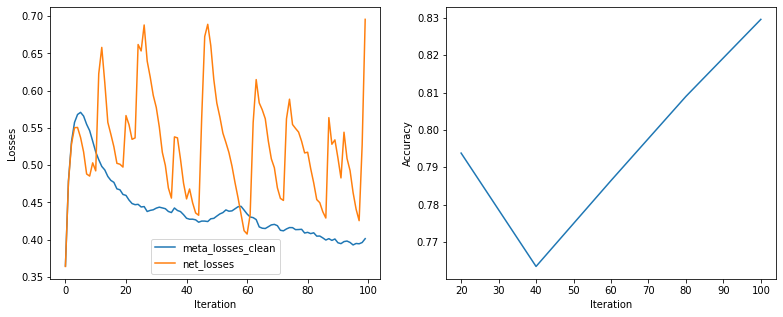

100%|██████████| 100/100 [03:15<00:00,  1.95s/it]



overall TPR : 0.543
priv TPR : 0.494
unpriv TPR : 0.552
Eq. Opp : 0.057

overall FPR : 0.076
priv FPR : 0.106
unpriv FPR : 0.028
diff FPR : 0.077

overall ACC : 0.830
priv ACC : 0.787
unpriv ACC : 0.916
diff ACC : 0.129



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28557117601001875
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1652608866222047


 11%|█         | 11/100 [00:21<02:51,  1.93s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-k2nn8n8o'
 19%|█▉        | 19/100 [00:36<02:35,  1.92s/it]

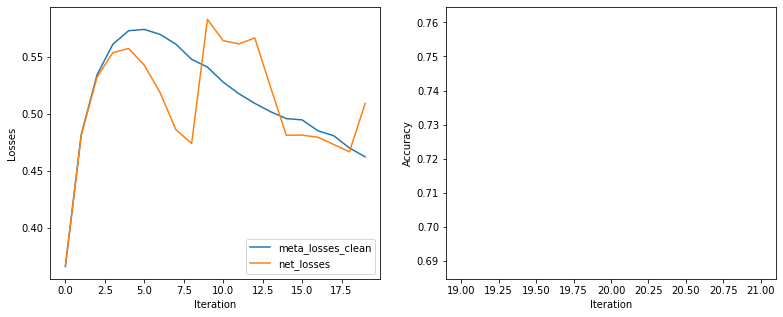

 39%|███▉      | 39/100 [01:16<01:56,  1.90s/it]

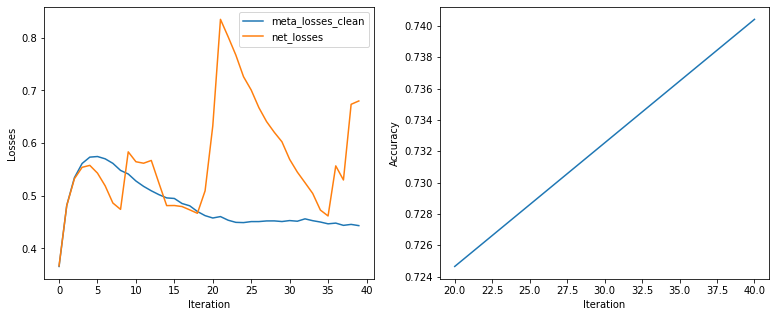

 59%|█████▉    | 59/100 [01:55<01:18,  1.91s/it]

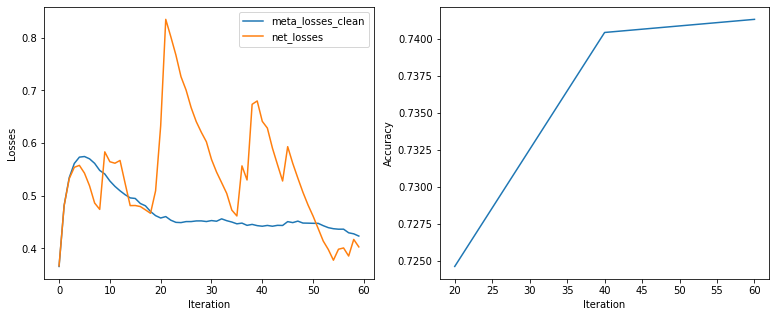

 79%|███████▉  | 79/100 [02:35<00:40,  1.93s/it]

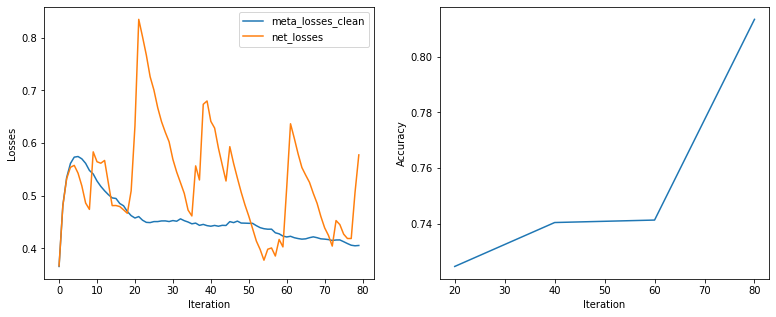

 99%|█████████▉| 99/100 [03:15<00:01,  1.93s/it]

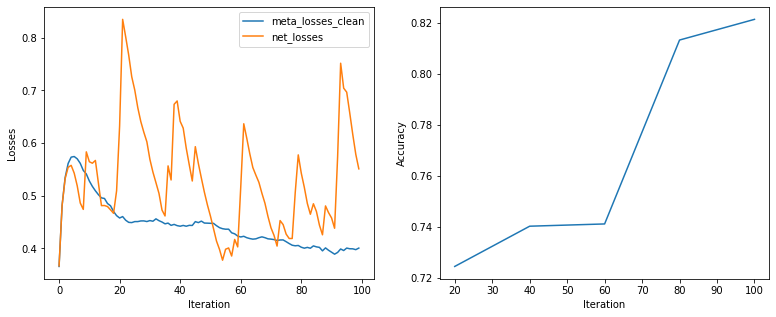

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.529
priv TPR : 0.463
unpriv TPR : 0.540
Eq. Opp : 0.077

overall FPR : 0.082
priv FPR : 0.114
unpriv FPR : 0.030
diff FPR : 0.084

overall ACC : 0.821
priv ACC : 0.778
unpriv ACC : 0.913
diff ACC : 0.136



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2904871233793894
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16853932584269657


 19%|█▉        | 19/100 [00:37<02:40,  1.98s/it]

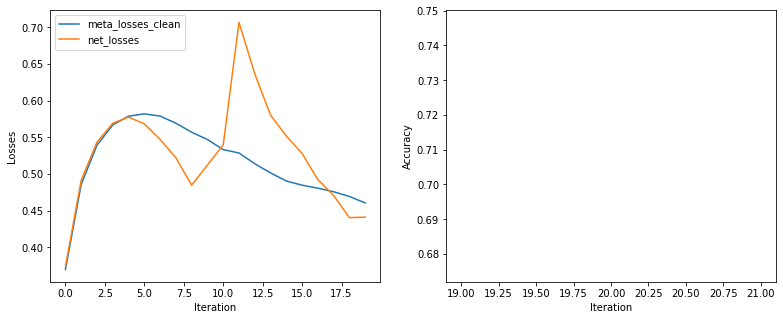

 39%|███▉      | 39/100 [01:17<01:59,  1.96s/it]

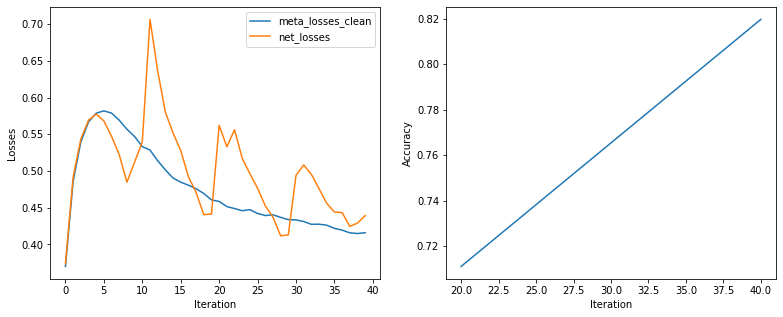

 59%|█████▉    | 59/100 [01:57<01:20,  1.97s/it]

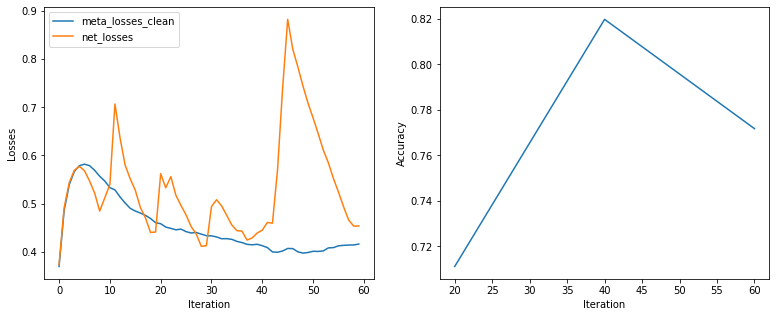

 79%|███████▉  | 79/100 [02:38<00:41,  1.97s/it]

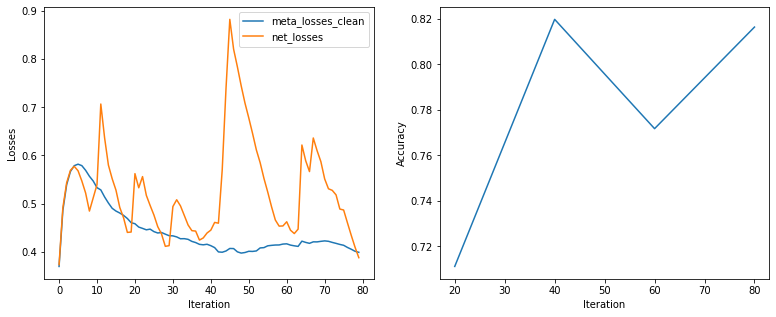

 99%|█████████▉| 99/100 [03:19<00:01,  1.99s/it]

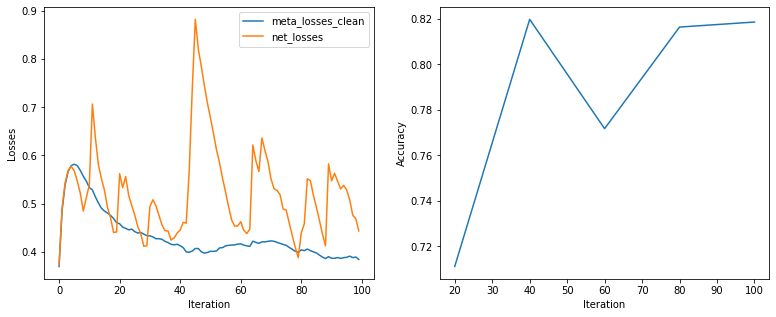

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.664
priv TPR : 0.435
unpriv TPR : 0.701
Eq. Opp : 0.266

overall FPR : 0.130
priv FPR : 0.196
unpriv FPR : 0.024
diff FPR : 0.171

overall ACC : 0.819
priv ACC : 0.772
unpriv ACC : 0.918
diff ACC : 0.147



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28478686224432287
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1647393179145433


 19%|█▉        | 19/100 [00:37<02:40,  1.98s/it]

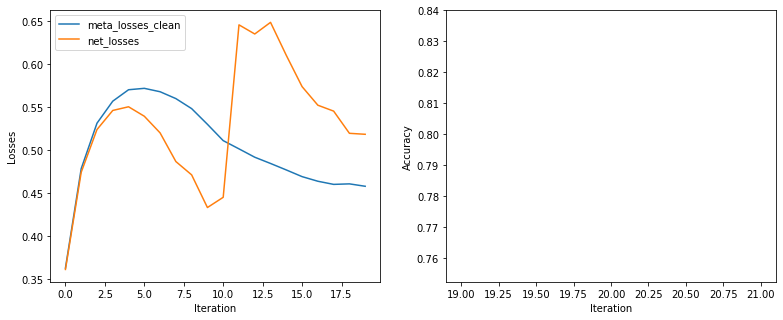

 39%|███▉      | 39/100 [01:18<02:00,  1.97s/it]

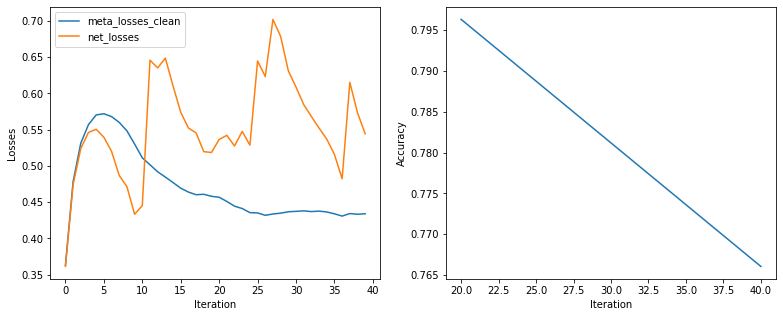

 59%|█████▉    | 59/100 [02:00<01:24,  2.07s/it]

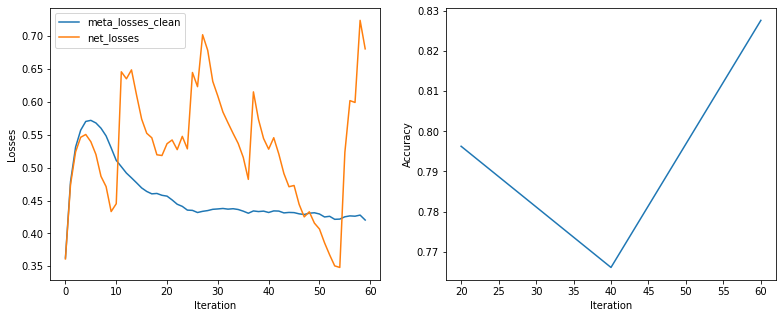

 71%|███████   | 71/100 [02:26<01:00,  2.08s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ciuqana4'
 79%|███████▉  | 79/100 [02:42<00:42,  2.03s/it]

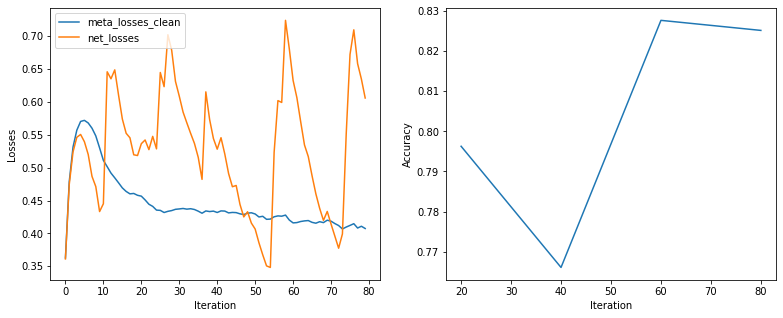

 99%|█████████▉| 99/100 [03:25<00:02,  2.06s/it]

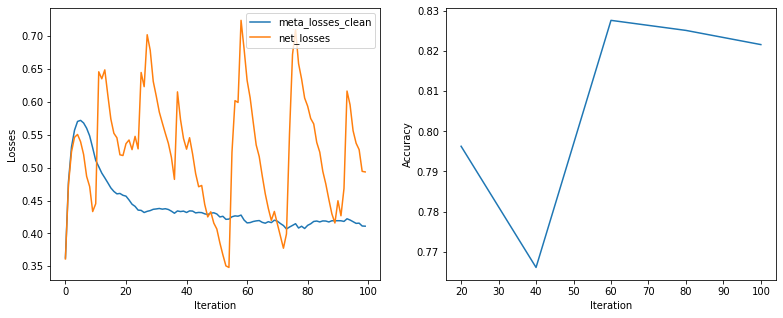

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.554
priv TPR : 0.498
unpriv TPR : 0.564
Eq. Opp : 0.066

overall FPR : 0.089
priv FPR : 0.118
unpriv FPR : 0.044
diff FPR : 0.074

overall ACC : 0.822
priv ACC : 0.781
unpriv ACC : 0.904
diff ACC : 0.123



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28478686224432287
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16473931791454327
poi ratio: 0.4


 19%|█▉        | 19/100 [00:39<02:49,  2.10s/it]

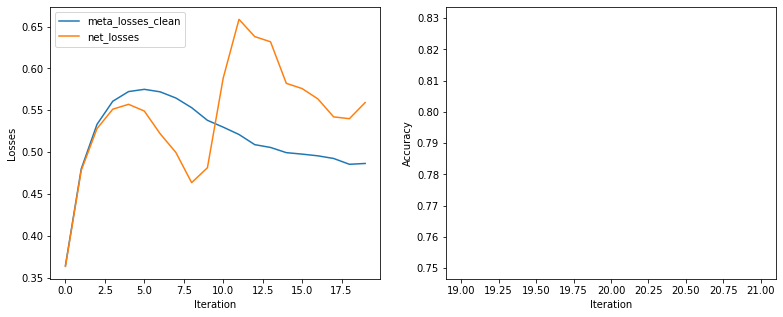

 39%|███▉      | 39/100 [01:22<02:07,  2.09s/it]

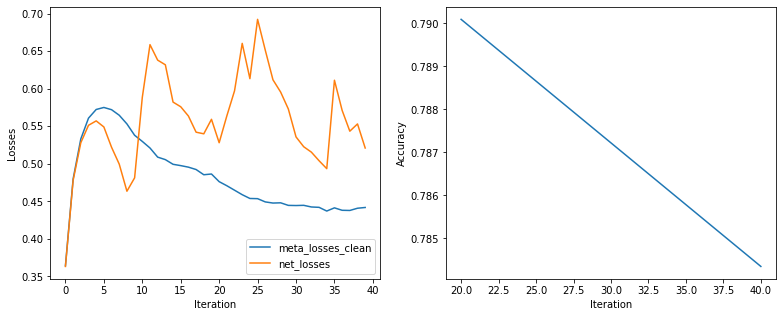

 59%|█████▉    | 59/100 [02:06<01:28,  2.15s/it]

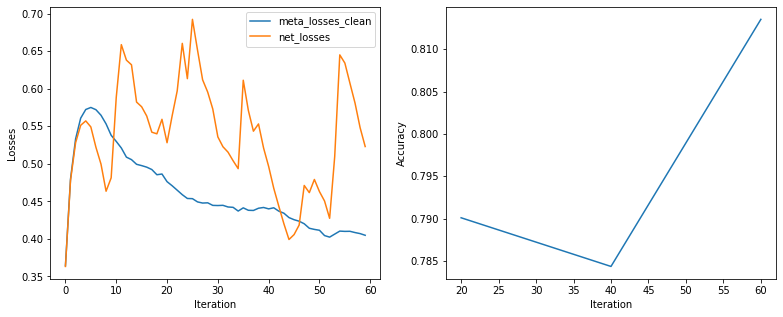

 79%|███████▉  | 79/100 [02:49<00:44,  2.12s/it]

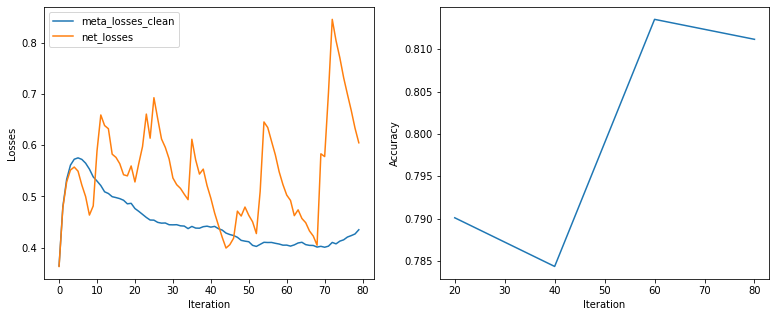

 99%|█████████▉| 99/100 [03:32<00:02,  2.11s/it]

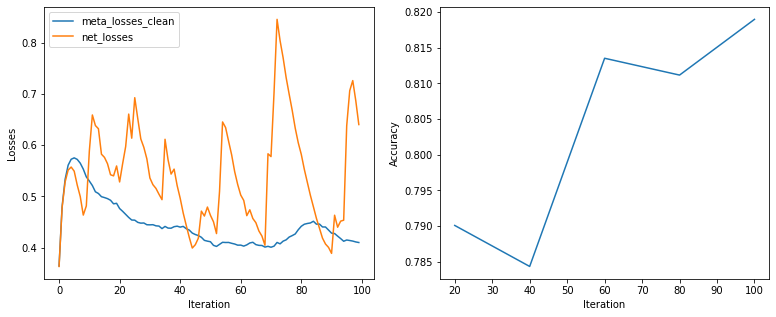

100%|██████████| 100/100 [03:36<00:00,  2.16s/it]



overall TPR : 0.521
priv TPR : 0.325
unpriv TPR : 0.556
Eq. Opp : 0.232

overall FPR : 0.078
priv FPR : 0.111
unpriv FPR : 0.023
diff FPR : 0.087

overall ACC : 0.819
priv ACC : 0.783
unpriv ACC : 0.896
diff ACC : 0.113



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28537503989092367
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16513041772896642


 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

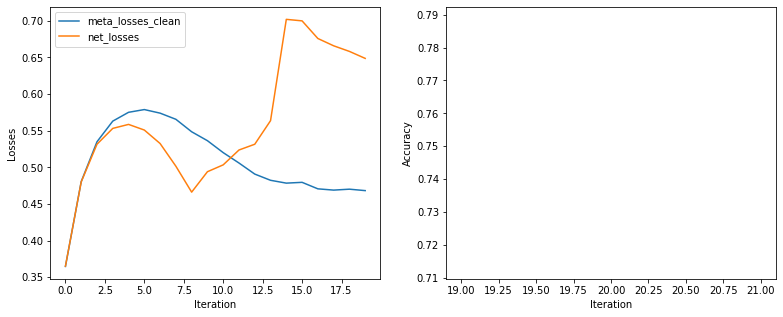

 39%|███▉      | 39/100 [01:24<02:09,  2.13s/it]

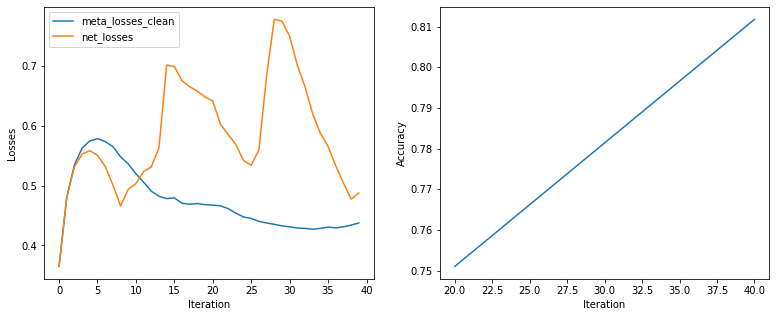

 59%|█████▉    | 59/100 [02:08<01:26,  2.11s/it]

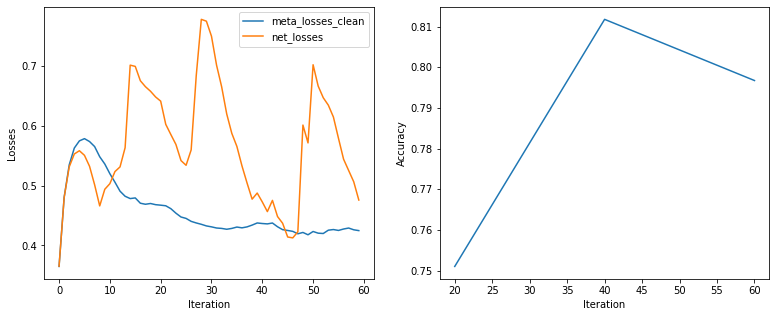

 79%|███████▉  | 79/100 [02:52<00:44,  2.12s/it]

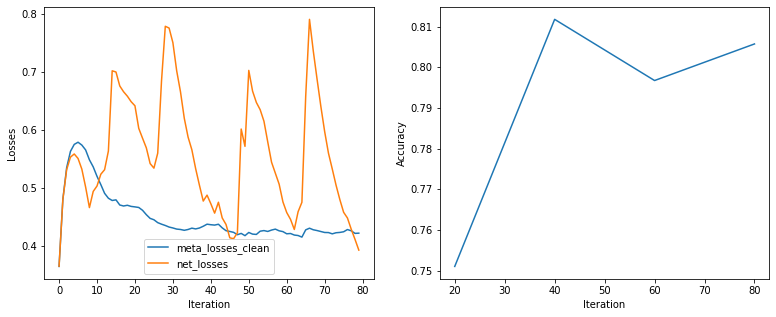

 99%|█████████▉| 99/100 [03:35<00:02,  2.13s/it]

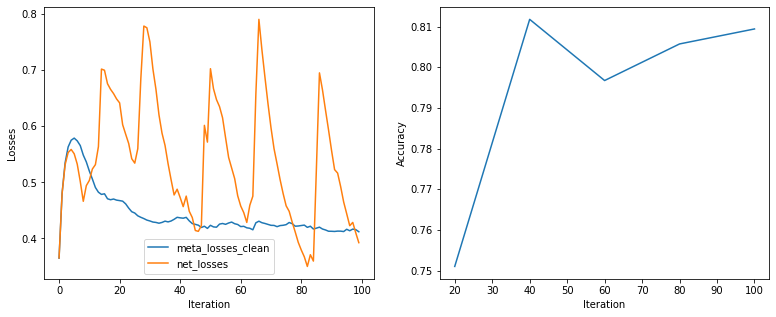

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.620
priv TPR : 0.335
unpriv TPR : 0.666
Eq. Opp : 0.331

overall FPR : 0.128
priv FPR : 0.195
unpriv FPR : 0.018
diff FPR : 0.177

overall ACC : 0.809
priv ACC : 0.762
unpriv ACC : 0.912
diff ACC : 0.150



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.27464636973376927
statistical_parity_difference : 0.0
generalized_entropy_index :  0.15803259604190925


 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

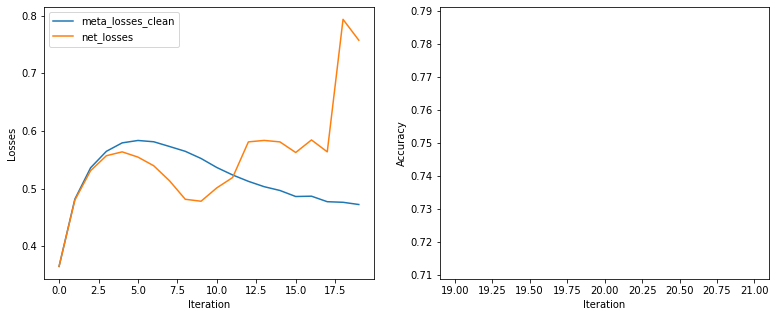

 39%|███▉      | 39/100 [01:26<02:13,  2.18s/it]

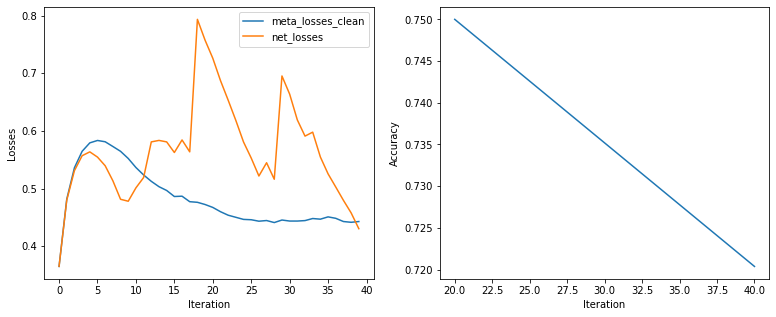

 59%|█████▉    | 59/100 [02:10<01:28,  2.16s/it]

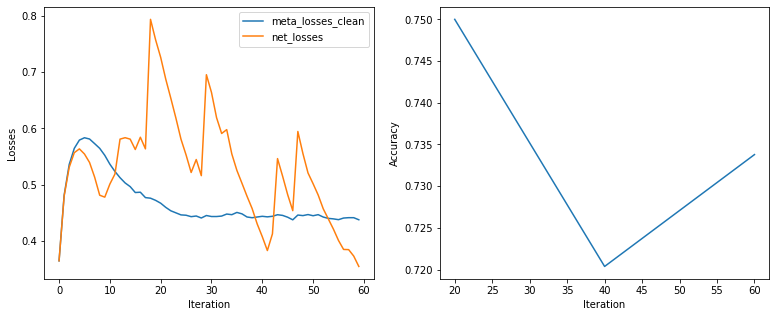

 79%|███████▉  | 79/100 [02:55<00:45,  2.18s/it]

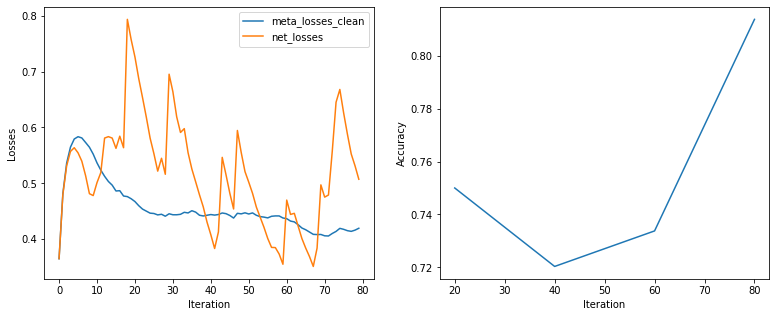

 99%|█████████▉| 99/100 [03:40<00:02,  2.18s/it]

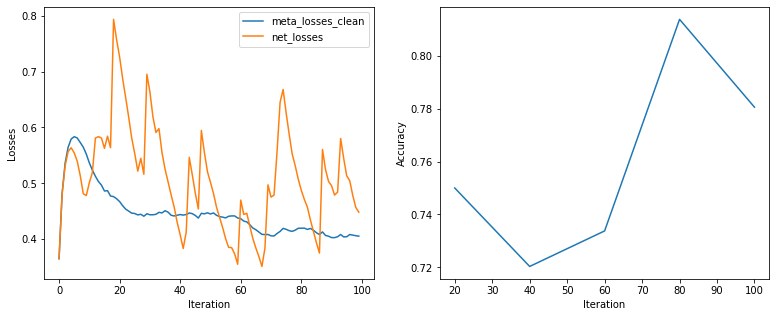

100%|██████████| 100/100 [03:43<00:00,  2.24s/it]



overall TPR : 0.698
priv TPR : 0.537
unpriv TPR : 0.726
Eq. Opp : 0.189

overall FPR : 0.192
priv FPR : 0.255
unpriv FPR : 0.090
diff FPR : 0.165

overall ACC : 0.781
priv ACC : 0.739
unpriv ACC : 0.867
diff ACC : 0.128



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28478686224432287
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1647393179145433


 19%|█▉        | 19/100 [00:41<02:55,  2.16s/it]

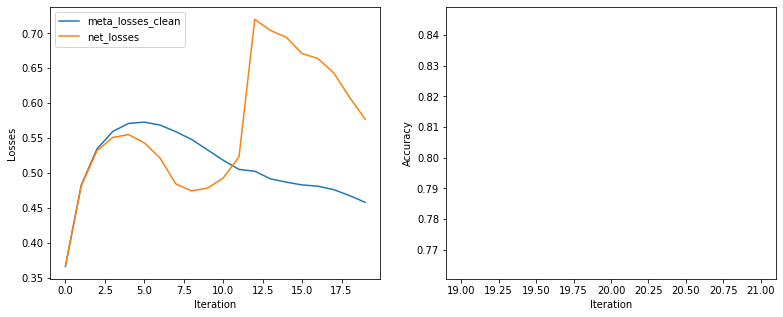

 39%|███▉      | 39/100 [01:26<02:13,  2.18s/it]

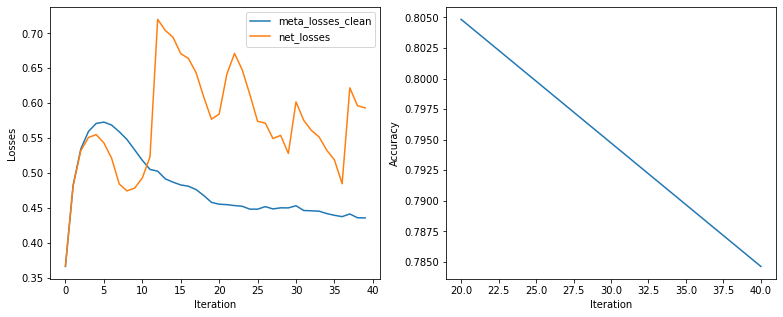

 59%|█████▉    | 59/100 [02:11<01:29,  2.18s/it]

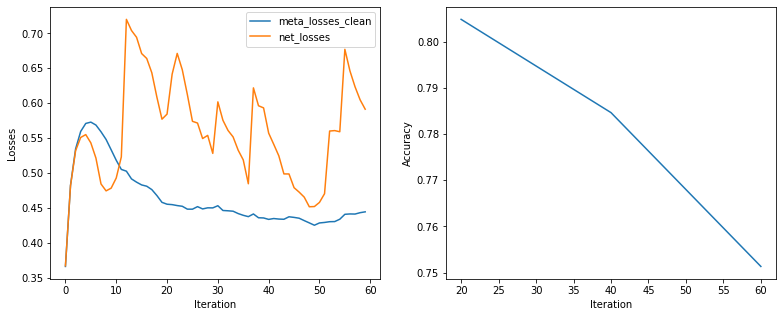

 60%|██████    | 60/100 [02:15<01:44,  2.61s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-xiy_9weh'
 79%|███████▉  | 79/100 [02:56<00:45,  2.18s/it]

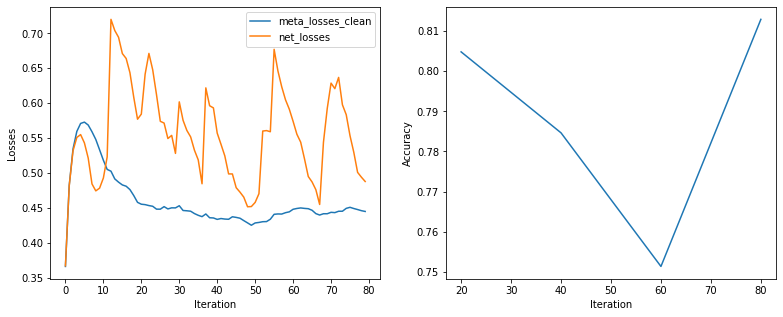

 99%|█████████▉| 99/100 [03:41<00:02,  2.17s/it]

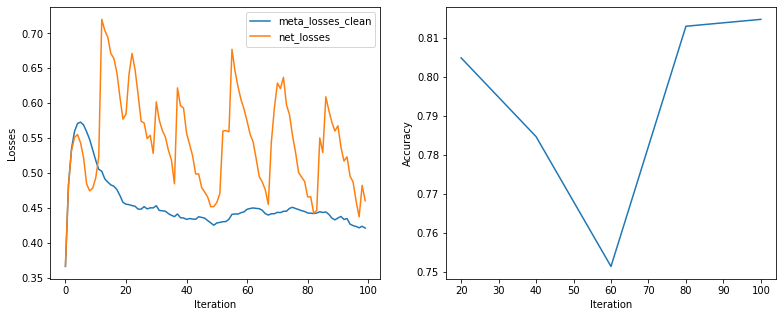

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.593
priv TPR : 0.348
unpriv TPR : 0.635
Eq. Opp : 0.286

overall FPR : 0.111
priv FPR : 0.169
unpriv FPR : 0.020
diff FPR : 0.149

overall ACC : 0.815
priv ACC : 0.769
unpriv ACC : 0.910
diff ACC : 0.141



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2802889569394706
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16175609756097567


  8%|▊         | 8/100 [00:17<03:26,  2.25s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2c08ngr_'
 19%|█▉        | 19/100 [00:42<03:01,  2.24s/it]

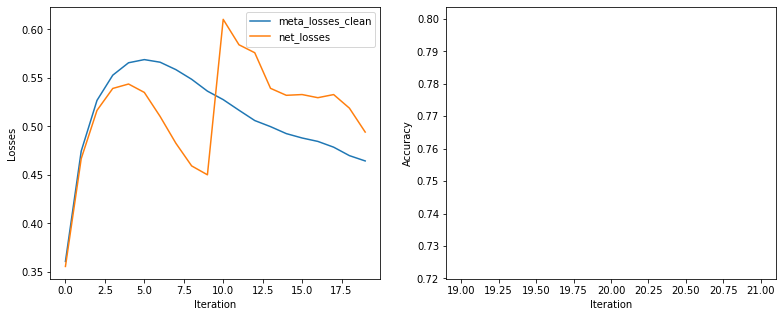

 39%|███▉      | 39/100 [01:30<02:36,  2.56s/it]

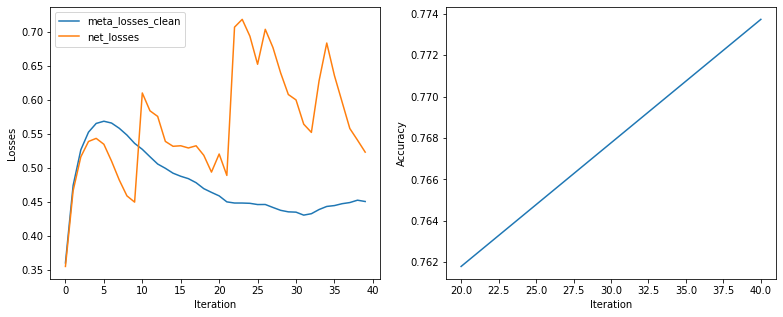

 59%|█████▉    | 59/100 [02:18<01:31,  2.24s/it]

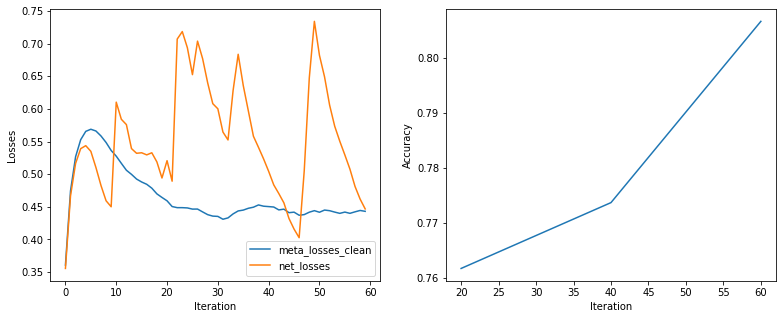

 79%|███████▉  | 79/100 [03:04<00:45,  2.18s/it]

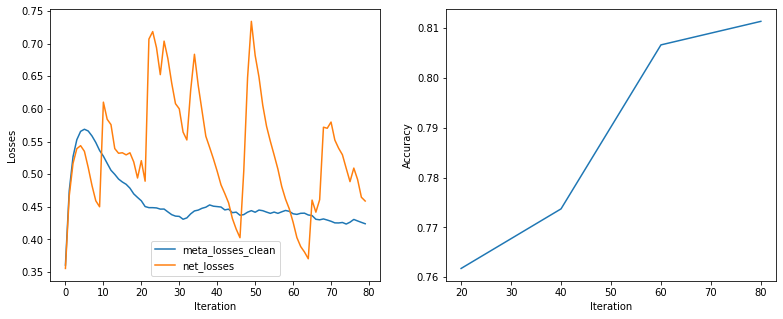

 99%|█████████▉| 99/100 [03:50<00:02,  2.22s/it]

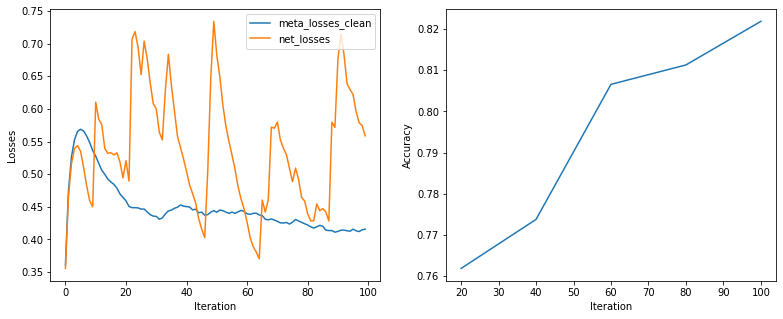

  0%|          | 0/100 [00:00<?, ?it/s]


overall TPR : 0.519
priv TPR : 0.374
unpriv TPR : 0.542
Eq. Opp : 0.168

overall FPR : 0.075
priv FPR : 0.108
unpriv FPR : 0.020
diff FPR : 0.088

overall ACC : 0.822
priv ACC : 0.779
unpriv ACC : 0.914
diff ACC : 0.135



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2800938540220631
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16162699960983218
poi ratio: 0.5


 19%|█▉        | 19/100 [00:42<03:02,  2.26s/it]

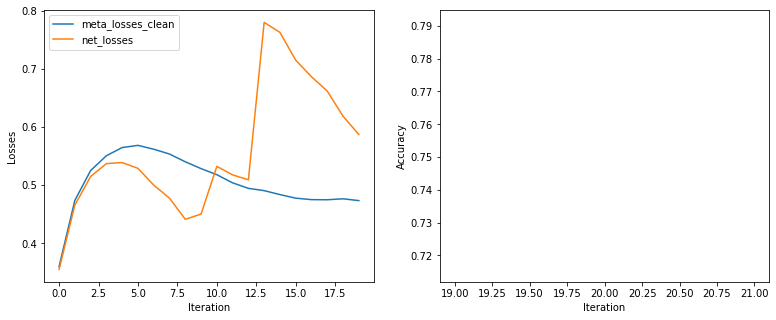

 39%|███▉      | 39/100 [01:29<02:15,  2.23s/it]

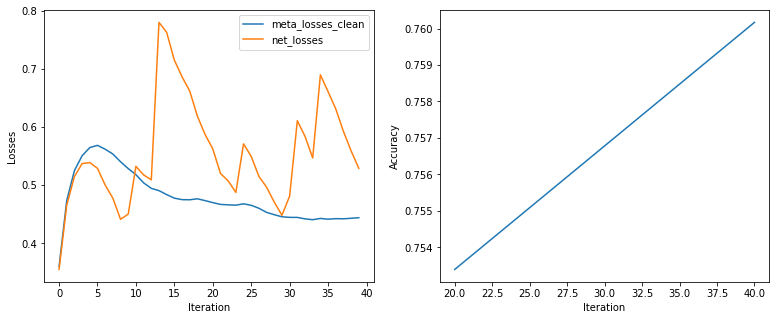

 59%|█████▉    | 59/100 [02:15<01:32,  2.25s/it]

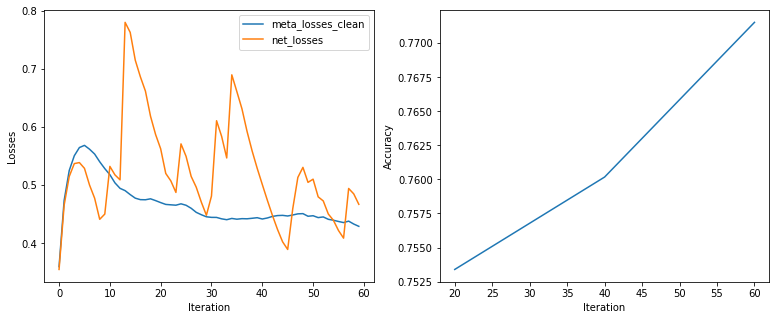

 79%|███████▉  | 79/100 [03:02<00:47,  2.24s/it]

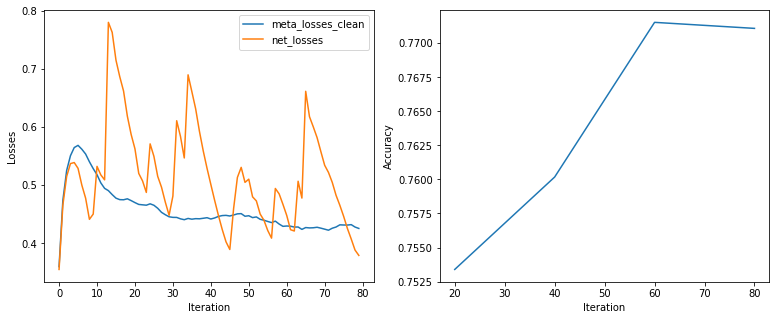

 99%|█████████▉| 99/100 [03:49<00:02,  2.27s/it]

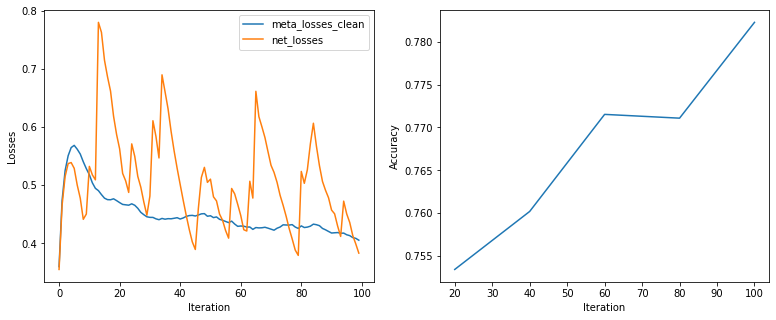

100%|██████████| 100/100 [03:52<00:00,  2.33s/it]



overall TPR : 0.693
priv TPR : 0.385
unpriv TPR : 0.749
Eq. Opp : 0.363

overall FPR : 0.188
priv FPR : 0.288
unpriv FPR : 0.024
diff FPR : 0.265

overall ACC : 0.782
priv ACC : 0.723
unpriv ACC : 0.907
diff ACC : 0.184



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2891082203735521
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16761811023622059


 19%|█▉        | 19/100 [00:43<03:07,  2.31s/it]

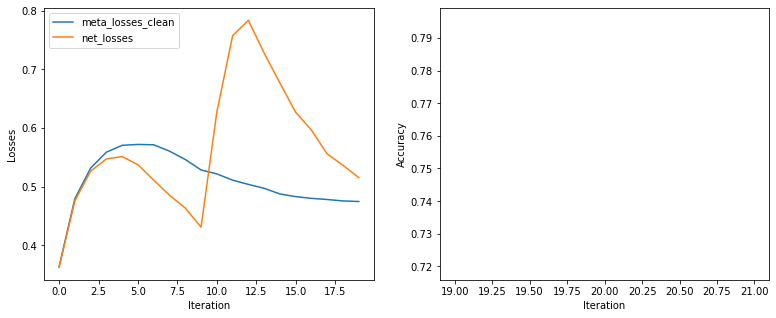

 39%|███▉      | 39/100 [01:30<02:20,  2.30s/it]

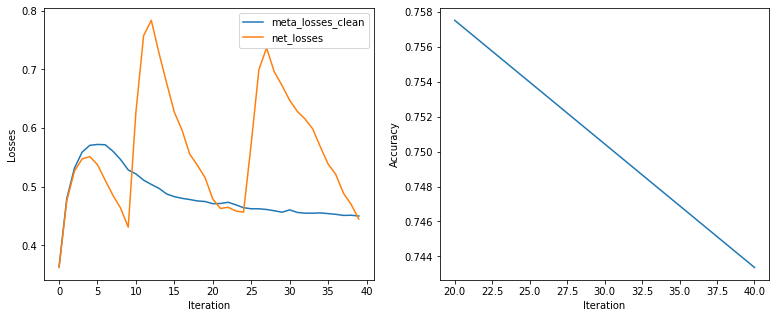

 59%|█████▉    | 59/100 [02:18<01:34,  2.32s/it]

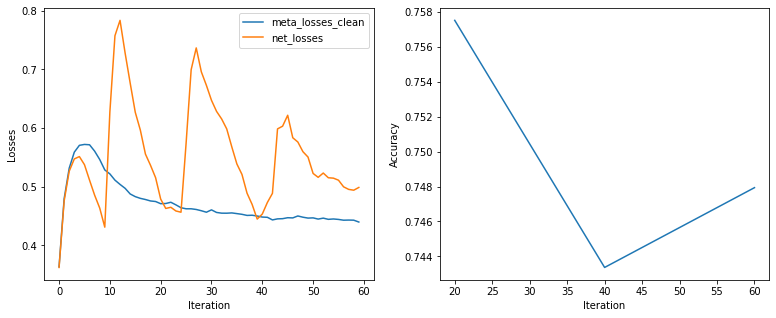

 79%|███████▉  | 79/100 [03:06<00:48,  2.30s/it]

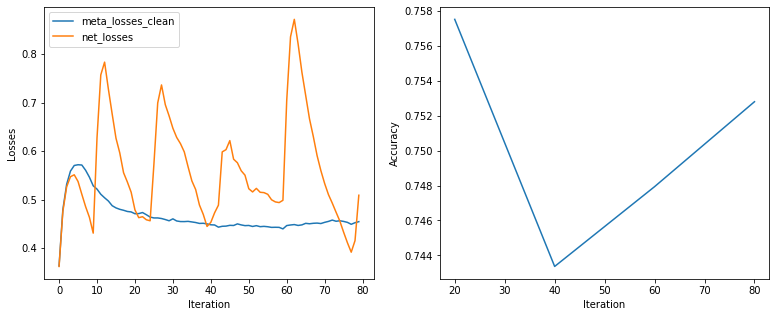

 99%|█████████▉| 99/100 [03:53<00:02,  2.29s/it]

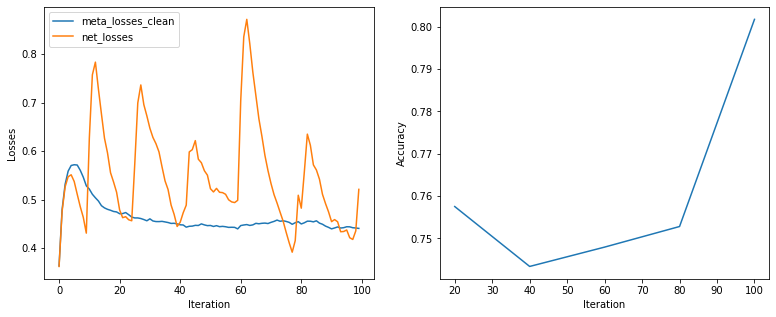

100%|██████████| 100/100 [03:57<00:00,  2.37s/it]



overall TPR : 0.630
priv TPR : 0.296
unpriv TPR : 0.689
Eq. Opp : 0.393

overall FPR : 0.143
priv FPR : 0.228
unpriv FPR : 0.010
diff FPR : 0.218

overall ACC : 0.802
priv ACC : 0.746
unpriv ACC : 0.913
diff ACC : 0.167



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2795087735568112
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1612400077987913


 19%|█▉        | 19/100 [00:43<03:08,  2.33s/it]

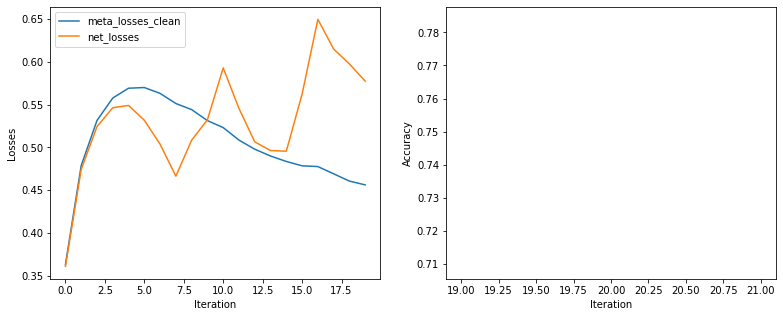

 39%|███▉      | 39/100 [01:31<02:22,  2.33s/it]

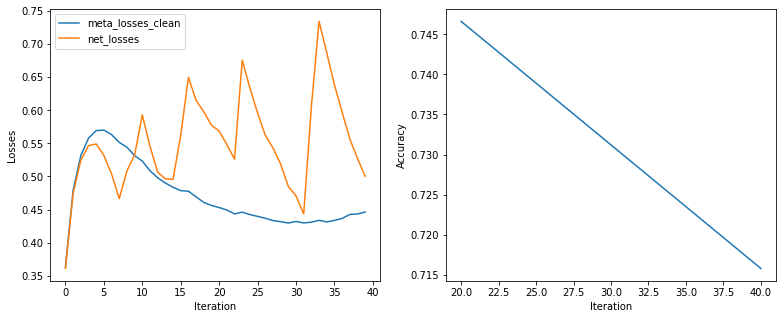

 59%|█████▉    | 59/100 [02:19<01:39,  2.42s/it]

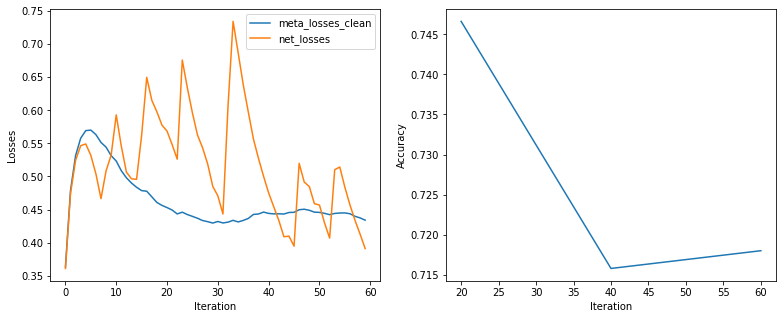

 79%|███████▉  | 79/100 [03:07<00:48,  2.33s/it]

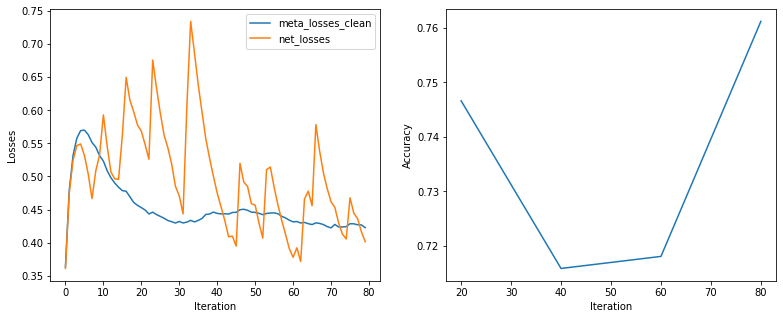

 99%|█████████▉| 99/100 [03:55<00:02,  2.36s/it]

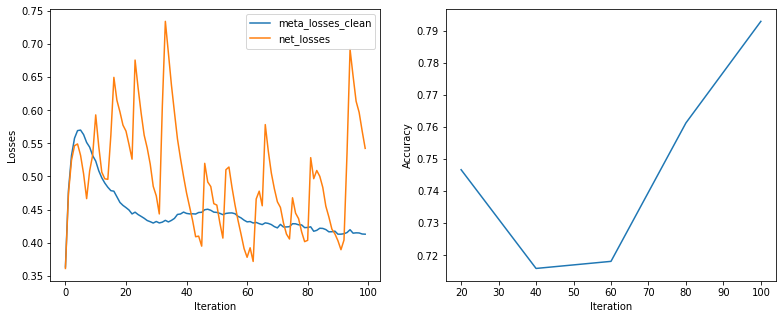

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]



overall TPR : 0.554
priv TPR : 0.233
unpriv TPR : 0.617
Eq. Opp : 0.384

overall FPR : 0.126
priv FPR : 0.198
unpriv FPR : 0.007
diff FPR : 0.191

overall ACC : 0.793
priv ACC : 0.744
unpriv ACC : 0.896
diff ACC : 0.152



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.28851784349917703
statistical_parity_difference : 0.0
generalized_entropy_index :  0.16722408026755847


 19%|█▉        | 19/100 [00:44<03:10,  2.35s/it]

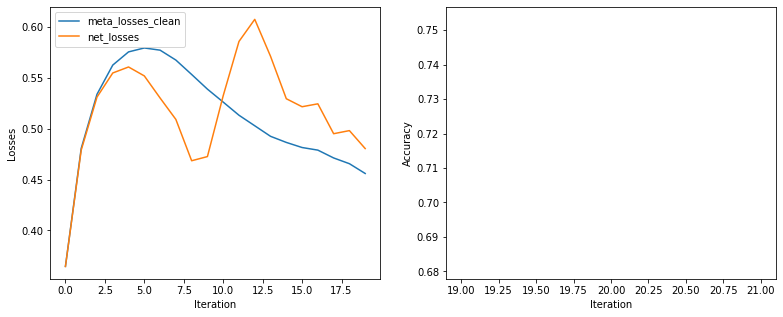

 39%|███▉      | 39/100 [01:33<02:21,  2.32s/it]

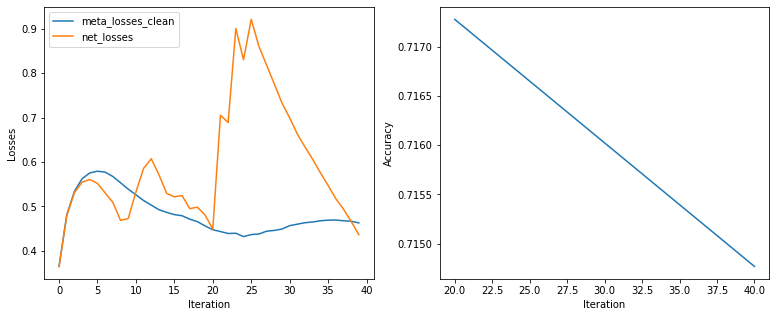

 59%|█████▉    | 59/100 [02:21<01:34,  2.32s/it]

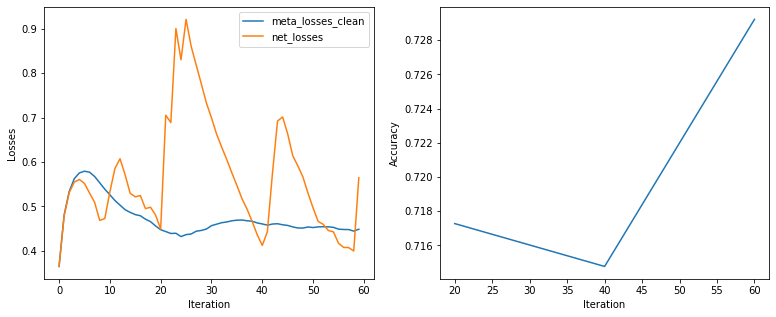

 79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]

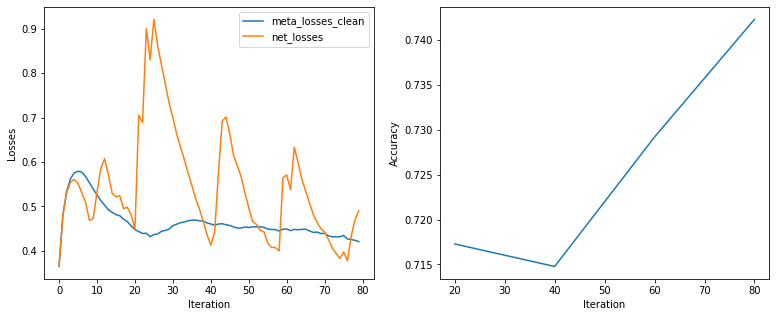

 99%|█████████▉| 99/100 [03:58<00:02,  2.35s/it]

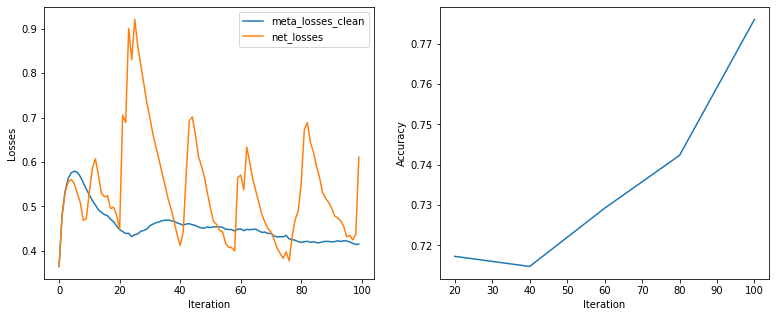

100%|██████████| 100/100 [04:01<00:00,  2.42s/it]



overall TPR : 0.674
priv TPR : 0.372
unpriv TPR : 0.728
Eq. Opp : 0.356

overall FPR : 0.191
priv FPR : 0.297
unpriv FPR : 0.019
diff FPR : 0.278

overall ACC : 0.776
priv ACC : 0.711
unpriv ACC : 0.912
diff ACC : 0.201



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2828287648887088
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1634389671361502


 19%|█▉        | 19/100 [00:43<03:06,  2.30s/it]

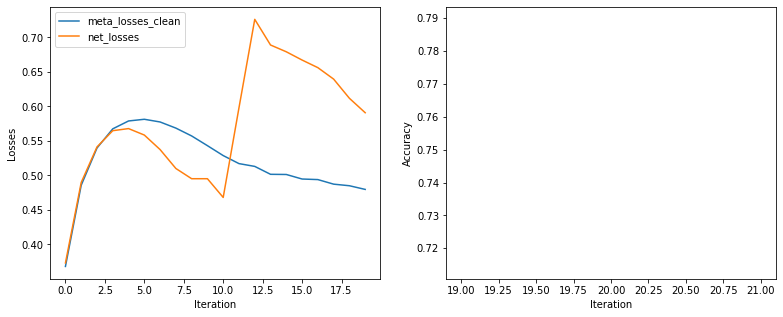

 39%|███▉      | 39/100 [01:31<02:21,  2.31s/it]

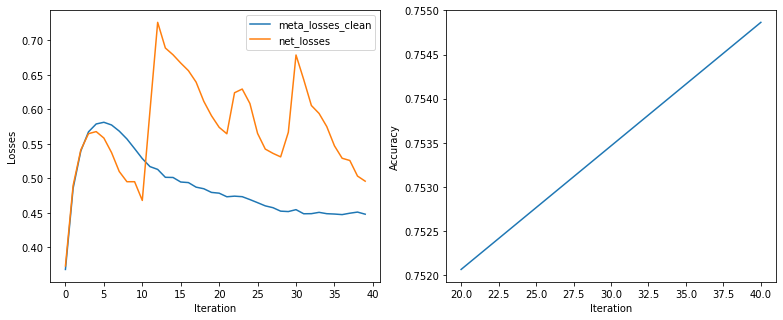

 54%|█████▍    | 54/100 [02:07<01:46,  2.31s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-wgm6m1c7'
 59%|█████▉    | 59/100 [02:19<01:34,  2.32s/it]

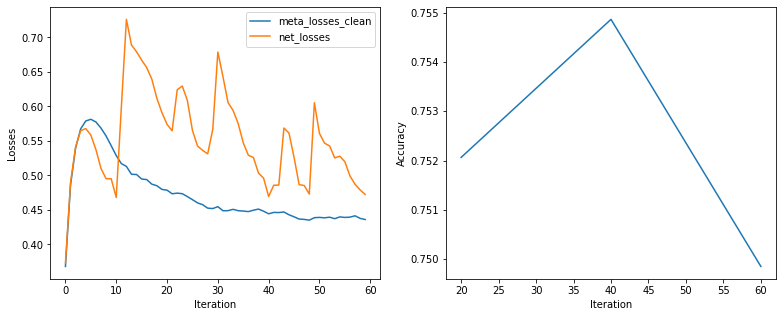

 79%|███████▉  | 79/100 [03:06<00:48,  2.31s/it]

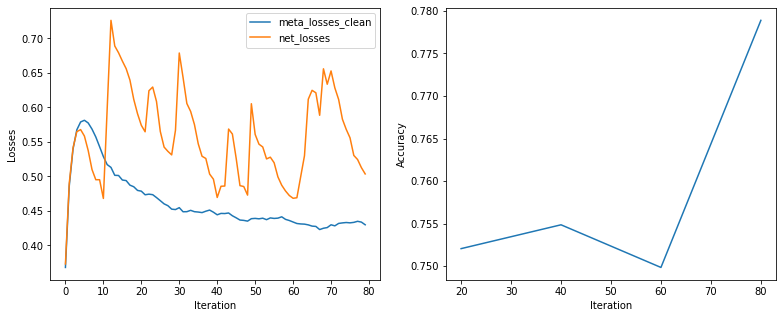

 99%|█████████▉| 99/100 [03:54<00:02,  2.31s/it]

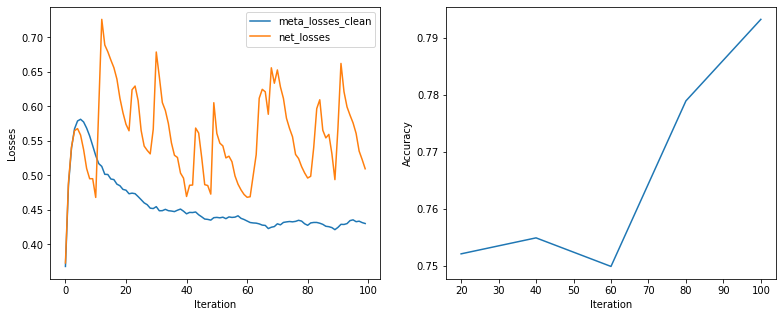

100%|██████████| 100/100 [03:57<00:00,  2.38s/it]



overall TPR : 0.395
priv TPR : 0.004
unpriv TPR : 0.467
Eq. Opp : 0.463

overall FPR : 0.076
priv FPR : 0.123
unpriv FPR : 0.000
diff FPR : 0.123

overall ACC : 0.793
priv ACC : 0.749
unpriv ACC : 0.884
diff ACC : 0.135



balanced acc : 0.5
disparate_impact : nan
theil_index : 0.2740644668951205
statistical_parity_difference : 0.0
generalized_entropy_index :  0.1576497963932518


In [17]:
results_dict = {}
for poi_ratio in np.linspace(0.1, 0.5, 5):
    print('poi ratio:', poi_ratio)
    results_dict[poi_ratio] = {}
    results_dict[poi_ratio]['EqOdds'] =[]
    results_dict[poi_ratio]['Acc'] = []
    results_dict[poi_ratio]['DISP'] = []
    results_dict[poi_ratio]['EqOpp']= []
    results_dict[poi_ratio]['Acc_diff'] = []

    results_dict[poi_ratio]['total_tpr'] =[]
    results_dict[poi_ratio]['total_fpr'] =[]

    results_dict[poi_ratio]['total_tpr_priv'] =[]
    results_dict[poi_ratio]['total_tpr_unpriv'] =[]
    results_dict[poi_ratio]['total_fpr_priv'] =[]
    results_dict[poi_ratio]['total_fpr_unpriv'] =[]

    for repeat in range(5):
        epochs = range(1, 51)
        data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
        data_valid, data_test = data_vt.split([0.5], shuffle=True)

        input_size = dataset[data_name].features.shape[-1] - 1
        latent_size = 512
        hidden_size = 512

        idx = np.where(data_train.features[:, sens_idx] == 1)[0]
        poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

        #label poisoning
        data_train.labels[poison_idx] = abs(1 - data_train.labels[poison_idx])

        d_train = Dataset(data_train, sens_idx)
        d_valid = Dataset(data_valid, sens_idx)
        d_test = Dataset(data_test, sens_idx)


        #bs_train, bs_valid, bs_test = len(d_train), len(d_valid), len(d_test)
        bs_train, bs_valid, bs_test = 256, 256, 256
        # bs_train, bs_valid, bs_test = 64, 64, 64

        trainloader = torch.utils.data.DataLoader(
            d_train,
            batch_size=bs_train,
            shuffle=True,
            num_workers=workers)

        validloader = torch.utils.data.DataLoader(
            d_valid,
            batch_size=bs_valid,
            shuffle=True,
            num_workers=workers)
        testloader = torch.utils.data.DataLoader(
            d_test,
            batch_size=bs_test,
            shuffle=True,
            num_workers=workers)


        train_LWE(results_dict)

In [18]:
results_dict

{0.1: {'EqOdds': [tensor([0.2586], device='cuda:0'),
   tensor([0.3650], device='cuda:0'),
   tensor([0.2848], device='cuda:0'),
   tensor([0.1465], device='cuda:0'),
   tensor([0.2961], device='cuda:0')],
  'Acc': [tensor([0.8197], device='cuda:0'),
   tensor([0.8275], device='cuda:0'),
   tensor([0.8193], device='cuda:0'),
   tensor([0.8269], device='cuda:0'),
   tensor([0.8246], device='cuda:0')],
  'DISP': [nan, nan, nan, nan, nan],
  'EqOpp': [tensor([0.1441], device='cuda:0'),
   tensor([0.2373], device='cuda:0'),
   tensor([0.1493], device='cuda:0'),
   tensor([0.0578], device='cuda:0'),
   tensor([0.1738], device='cuda:0')],
  'Acc_diff': [tensor([0.1257], device='cuda:0'),
   tensor([0.1195], device='cuda:0'),
   tensor([0.1248], device='cuda:0'),
   tensor([0.1222], device='cuda:0'),
   tensor([0.1268], device='cuda:0')],
  'total_tpr': [tensor([0.6281], device='cuda:0'),
   tensor([0.6128], device='cuda:0'),
   tensor([0.6823], device='cuda:0'),
   tensor([0.6138], device='c

In [20]:
data_name

'adult'

In [21]:
with open(f'results/{data_name}/robust_LWE_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

#### Poisoning

In [44]:
#COMPAS setup
results_dict = {}

for poi_ratio in np.linspace(0.1, 0.5, 5):
    data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
    data_valid, data_test = data_vt.split([0.5], shuffle=True)

    idx = np.where(data_train.features[:, sens_idx] == 1)[0]
    poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

    #label poisoning
    data_train.labels[poison_idx] = 1 - data_train.labels[poison_idx]

    X_train = torch.FloatTensor(data_train.features[:, ~sens_loc])
    y_train = torch.FloatTensor(data_train.labels)
    s1_train = torch.FloatTensor(data_train.features[:, sens_idx]).view(-1,1)

    X_val = torch.FloatTensor(data_valid.features[:, ~sens_loc])
    y_val = torch.FloatTensor(data_valid.labels)
    s1_val = torch.FloatTensor(data_valid.features[:, sens_idx]).view(-1,1)

    X_test = torch.FloatTensor(data_test.features[:, ~sens_loc])
    y_test = torch.FloatTensor(data_test.labels)
    s1_test = torch.FloatTensor(data_test.features[:, sens_idx]).view(-1,1)

    XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
    XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
    XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

    train_result = []
    train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
    val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
    test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

    train_opt = Namespace(val=len(y_val), n_epochs=200, k=1, lr_g=1e-3, lr_f=1e-4, lr_r=1e-4)
    seed = 1

    lambda_f_set = [0.1] # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.1 # Lambda value for the robustness discriminator of FR-Train.

    results_dict[poi_ratio] = {}
    
    data_train = Dataset(X_train, s1_train, y_train)
    data_valid = Dataset(X_val, s1_val, y_val)
    data_test = Dataset(X_test, s1_test, y_test)

    trainloader = torch.utils.data.DataLoader(
        data_train,
        batch_size=128,
        shuffle=True,
        )
    validloader = torch.utils.data.DataLoader(
        data_valid,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )
    testloader = torch.utils.data.DataLoader(
        data_test,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )


    for lambda_f in lambda_f_set:
        train_model_adult(results_dict[poi_ratio], train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, lambda_r = lambda_r, seed = seed)
    


[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 0.694809] [D_R loss: 0.588161] [G loss: 4.766986]
VALID DATA
overall TPR : 0.224
priv TPR : 0.258
unpriv TPR : 0.148
Eq. Opp : 0.110

overall FPR : 0.139
priv FPR : 0.129
unpriv FPR : 0.145
diff FPR : 0.016

overall ACC : 0.571
priv ACC : 0.576
unpriv ACC : 0.569
diff ACC : 0.008



TEST DATA
overall TPR : 0.202
priv TPR : 0.231
unpriv TPR : 0.145
Eq. Opp : 0.086

overall FPR : 0.103
priv FPR : 0.060
unpriv FPR : 0.131
diff FPR : 0.071

overall ACC : 0.562
priv ACC : 0.588
unpriv ACC : 0.548
diff ACC : 0.041



DIMP : 0.538
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 0.690723] [D_R loss: 1.004347] [G loss: 0.204525]
VALID DATA
overall TPR : 0.716
priv TPR : 0.729
unpriv TPR : 0.690
Eq. Opp : 0.039

overall FPR : 0.495
priv FPR : 0.508
unpriv FPR : 0.487
diff FPR : 0.021

overall ACC : 0.602
priv ACC : 0.573
unpriv ACC : 0.617
diff ACC : 0.044



TEST DATA
overall TPR : 0.705
priv TPR : 0.715
unpriv TPR : 0.685
Eq. Opp : 0.030

overall FPR :

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.680010] [D_R loss: 0.543620] [G loss: 0.279422]
VALID DATA
overall TPR : 0.577
priv TPR : 0.616
unpriv TPR : 0.496
Eq. Opp : 0.119

overall FPR : 0.334
priv FPR : 0.324
unpriv FPR : 0.340
diff FPR : 0.016

overall ACC : 0.625
priv ACC : 0.600
unpriv ACC : 0.639
diff ACC : 0.039



TEST DATA
overall TPR : 0.594
priv TPR : 0.603
unpriv TPR : 0.577
Eq. Opp : 0.025

overall FPR : 0.325
priv FPR : 0.291
unpriv FPR : 0.347
diff FPR : 0.057

overall ACC : 0.636
priv ACC : 0.651
unpriv ACC : 0.628
diff ACC : 0.023



DIMP : 0.879
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.678357] [D_R loss: 0.649717] [G loss: 0.227475]
VALID DATA
overall TPR : 0.528
priv TPR : 0.583
unpriv TPR : 0.411
Eq. Opp : 0.172

overall FPR : 0.282
priv FPR : 0.214
unpriv FPR : 0.325
diff FPR : 0.111

overall ACC : 0.632
priv ACC : 0.633
unpriv ACC : 0.631
diff ACC : 0.002



TEST DATA
overall TPR : 0.551
priv TPR : 0.615
unpriv TPR : 0.423
Eq. Opp : 0.192

overall FPR

[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.684285] [D_R loss: 0.628715] [G loss: 0.234564]
VALID DATA
overall TPR : 0.505
priv TPR : 0.582
unpriv TPR : 0.328
Eq. Opp : 0.254

overall FPR : 0.302
priv FPR : 0.326
unpriv FPR : 0.288
diff FPR : 0.037

overall ACC : 0.612
priv ACC : 0.532
unpriv ACC : 0.651
diff ACC : 0.119



TEST DATA
overall TPR : 0.484
priv TPR : 0.539
unpriv TPR : 0.362
Eq. Opp : 0.177

overall FPR : 0.249
priv FPR : 0.289
unpriv FPR : 0.224
diff FPR : 0.065

overall ACC : 0.629
priv ACC : 0.571
unpriv ACC : 0.661
diff ACC : 0.091



DIMP : 0.846
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.683957] [D_R loss: 0.640857] [G loss: 0.236264]
VALID DATA
overall TPR : 0.706
priv TPR : 0.730
unpriv TPR : 0.647
Eq. Opp : 0.084

overall FPR : 0.506
priv FPR : 0.617
unpriv FPR : 0.446
diff FPR : 0.171

overall ACC : 0.588
priv ACC : 0.488
unpriv ACC : 0.636
diff ACC : 0.148



TEST DATA
overall TPR : 0.706
priv TPR : 0.710
unpriv TPR : 0.696
Eq. Opp : 0.014

overall FPR

[Lambda: 0.100000] [Epoch 60/200] [D_F loss: 0.688775] [D_R loss: 0.720247] [G loss: 0.958846]
VALID DATA
overall TPR : 0.543
priv TPR : 0.588
unpriv TPR : 0.427
Eq. Opp : 0.161

overall FPR : 0.309
priv FPR : 0.314
unpriv FPR : 0.306
diff FPR : 0.008

overall ACC : 0.623
priv ACC : 0.582
unpriv ACC : 0.642
diff ACC : 0.060



TEST DATA
overall TPR : 0.482
priv TPR : 0.507
unpriv TPR : 0.424
Eq. Opp : 0.083

overall FPR : 0.314
priv FPR : 0.279
unpriv FPR : 0.337
diff FPR : 0.058

overall ACC : 0.590
priv ACC : 0.603
unpriv ACC : 0.583
diff ACC : 0.020



DIMP : 0.795
[Lambda: 0.100000] [Epoch 70/200] [D_F loss: 0.688516] [D_R loss: 0.917322] [G loss: 0.227753]
VALID DATA
overall TPR : 0.592
priv TPR : 0.627
unpriv TPR : 0.504
Eq. Opp : 0.123

overall FPR : 0.374
priv FPR : 0.398
unpriv FPR : 0.360
diff FPR : 0.037

overall ACC : 0.610
priv ACC : 0.563
unpriv ACC : 0.633
diff ACC : 0.070



TEST DATA
overall TPR : 0.567
priv TPR : 0.593
unpriv TPR : 0.504
Eq. Opp : 0.089

overall FPR :

[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 0.583197] [D_R loss: 1.624131] [G loss: 8.654215]
VALID DATA
overall TPR : 0.185
priv TPR : 0.132
unpriv TPR : 0.304
Eq. Opp : 0.172

overall FPR : 0.173
priv FPR : 0.296
unpriv FPR : 0.092
diff FPR : 0.204

overall ACC : 0.537
priv ACC : 0.548
unpriv ACC : 0.530
diff ACC : 0.018



TEST DATA
overall TPR : 0.237
priv TPR : 0.183
unpriv TPR : 0.366
Eq. Opp : 0.183

overall FPR : 0.174
priv FPR : 0.301
unpriv FPR : 0.092
diff FPR : 0.209

overall ACC : 0.551
priv ACC : 0.566
unpriv ACC : 0.543
diff ACC : 0.023



DIMP : 0.422
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 0.693887] [D_R loss: 0.961105] [G loss: 0.965591]
VALID DATA
overall TPR : 0.552
priv TPR : 0.542
unpriv TPR : 0.574
Eq. Opp : 0.032

overall FPR : 0.361
priv FPR : 0.416
unpriv FPR : 0.324
diff FPR : 0.092

overall ACC : 0.599
priv ACC : 0.580
unpriv ACC : 0.610
diff ACC : 0.030



TEST DATA
overall TPR : 0.539
priv TPR : 0.572
unpriv TPR : 0.460
Eq. Opp : 0.113

overall FPR :

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.679706] [D_R loss: 0.676911] [G loss: 0.211069]
VALID DATA
overall TPR : 0.517
priv TPR : 0.587
unpriv TPR : 0.358
Eq. Opp : 0.229

overall FPR : 0.337
priv FPR : 0.286
unpriv FPR : 0.371
diff FPR : 0.085

overall ACC : 0.597
priv ACC : 0.577
unpriv ACC : 0.608
diff ACC : 0.032



TEST DATA
overall TPR : 0.521
priv TPR : 0.603
unpriv TPR : 0.323
Eq. Opp : 0.281

overall FPR : 0.305
priv FPR : 0.270
unpriv FPR : 0.328
diff FPR : 0.057

overall ACC : 0.613
priv ACC : 0.566
unpriv ACC : 0.637
diff ACC : 0.071



DIMP : 0.622
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.678166] [D_R loss: 0.616668] [G loss: 0.188007]
VALID DATA
overall TPR : 0.656
priv TPR : 0.708
unpriv TPR : 0.537
Eq. Opp : 0.171

overall FPR : 0.448
priv FPR : 0.410
unpriv FPR : 0.473
diff FPR : 0.063

overall ACC : 0.599
priv ACC : 0.569
unpriv ACC : 0.616
diff ACC : 0.047



TEST DATA
overall TPR : 0.654
priv TPR : 0.723
unpriv TPR : 0.488
Eq. Opp : 0.235

overall FPR

TEST DATA
overall TPR : 0.569
priv TPR : 0.550
unpriv TPR : 0.612
Eq. Opp : 0.062

overall FPR : 0.384
priv FPR : 0.538
unpriv FPR : 0.281
diff FPR : 0.257

overall ACC : 0.594
priv ACC : 0.525
unpriv ACC : 0.632
diff ACC : 0.107



DIMP : 0.739
[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.681453] [D_R loss: 0.706545] [G loss: 0.189696]
VALID DATA
overall TPR : 0.725
priv TPR : 0.722
unpriv TPR : 0.732
Eq. Opp : 0.010

overall FPR : 0.577
priv FPR : 0.696
unpriv FPR : 0.492
diff FPR : 0.204

overall ACC : 0.550
priv ACC : 0.436
unpriv ACC : 0.612
diff ACC : 0.175



TEST DATA
overall TPR : 0.705
priv TPR : 0.700
unpriv TPR : 0.715
Eq. Opp : 0.015

overall FPR : 0.591
priv FPR : 0.628
unpriv FPR : 0.566
diff FPR : 0.062

overall ACC : 0.550
priv ACC : 0.513
unpriv ACC : 0.571
diff ACC : 0.058



DIMP : 0.957
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.686425] [D_R loss: 0.847187] [G loss: 0.233886]
VALID DATA
overall TPR : 0.536
priv TPR : 0.553
unpriv TPR : 0.490
Eq. Opp : 0.063

In [81]:
#Adult setup
results_dict = {}

for poi_ratio in np.linspace(0.1, 0.5, 5):
    data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
    data_valid, data_test = data_vt.split([0.5], shuffle=True)

    idx = np.where(data_train.features[:, sens_idx] == 1)[0]
    poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

    #label poisoning
    data_train.labels[poison_idx] = 1 - data_train.labels[poison_idx]

    X_train = torch.FloatTensor(data_train.features[:, ~sens_loc])
    y_train = torch.FloatTensor(data_train.labels)
    s1_train = torch.FloatTensor(data_train.features[:, sens_idx]).view(-1,1)

    X_val = torch.FloatTensor(data_valid.features[:, ~sens_loc])
    y_val = torch.FloatTensor(data_valid.labels)
    s1_val = torch.FloatTensor(data_valid.features[:, sens_idx]).view(-1,1)

    X_test = torch.FloatTensor(data_test.features[:, ~sens_loc])
    y_test = torch.FloatTensor(data_test.labels)
    s1_test = torch.FloatTensor(data_test.features[:, sens_idx]).view(-1,1)

    XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
    XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
    XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

    train_result = []
    train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
    val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
    test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

    train_opt = Namespace(val=len(y_val), n_epochs=100, k=1, lr_g=1e-4, lr_f=1e-5, lr_r=1e-5)
    seed = 1

    lambda_f_set = [0.2] # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.2 # Lambda value for the robustness discriminator of FR-Train.

    results_dict[poi_ratio] = {}
    
    data_train = Dataset(X_train, s1_train, y_train)
    data_valid = Dataset(X_val, s1_val, y_val)
    data_test = Dataset(X_test, s1_test, y_test)

    trainloader = torch.utils.data.DataLoader(
        data_train,
        batch_size=128,
        shuffle=True,
        )
    validloader = torch.utils.data.DataLoader(
        data_valid,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )
    testloader = torch.utils.data.DataLoader(
        data_test,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )


    for lambda_f in lambda_f_set:
        train_model_adult(results_dict[poi_ratio], train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, lambda_r = lambda_r, seed = seed)
    


TypeError: __init__() takes 1 positional argument but 3 were given

In [84]:
#German setup
results_dict = {}

for poi_ratio in np.linspace(0.1, 0.5, 5):
    data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
    data_valid, data_test = data_vt.split([0.5], shuffle=True)

    idx = np.where(data_train.features[:, sens_idx] == 1)[0]
    poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

    #label poisoning
    data_train.labels[poison_idx] = 1 - data_train.labels[poison_idx]

    X_train = torch.FloatTensor(data_train.features[:, ~sens_loc])
    y_train = torch.FloatTensor(data_train.labels)
    s1_train = torch.FloatTensor(data_train.features[:, sens_idx]).view(-1,1)

    X_val = torch.FloatTensor(data_valid.features[:, ~sens_loc])
    y_val = torch.FloatTensor(data_valid.labels)
    s1_val = torch.FloatTensor(data_valid.features[:, sens_idx]).view(-1,1)

    X_test = torch.FloatTensor(data_test.features[:, ~sens_loc])
    y_test = torch.FloatTensor(data_test.labels)
    s1_test = torch.FloatTensor(data_test.features[:, sens_idx]).view(-1,1)

    XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
    XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
    XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

    train_result = []
    train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
    val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
    test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

    train_opt = Namespace(val=len(y_val), n_epochs=200, k=1, lr_g=1e-3, lr_f=1e-4, lr_r=1e-4)
    seed = 1

    lambda_f_set = [0.1] # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.1 # Lambda value for the robustness discriminator of FR-Train.

    results_dict[poi_ratio] = {}
    
    data_train = Dataset(X_train, s1_train, y_train)
    data_valid = Dataset(X_val, s1_val, y_val)
    data_test = Dataset(X_test, s1_test, y_test)

    trainloader = torch.utils.data.DataLoader(
        data_train,
        batch_size=128,
        shuffle=True,
        )
    validloader = torch.utils.data.DataLoader(
        data_valid,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )
    testloader = torch.utils.data.DataLoader(
        data_test,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )


    for lambda_f in lambda_f_set:
        train_model_adult(results_dict[poi_ratio], train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, lambda_r = lambda_r, seed = seed)
    


[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 30.000002] [D_R loss: 52.477028] [G loss: 33.262245]
VALID DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.680
priv ACC : 0.678
unpriv ACC : 0.684
diff ACC : 0.006



TEST DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.711
priv ACC : 0.719
unpriv ACC : 0.692
diff ACC : 0.027



DIMP : nan
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 1.978784] [D_R loss: 1.269961] [G loss: 0.630586]
VALID DATA
overall TPR : 0.385
priv TPR : 0.500
unpriv TPR : 0.345
Eq. Opp : 0.155

overall FPR : 0.292
priv FPR : 0.266
unpriv FPR : 0.360
diff FPR : 0.094

overall ACC : 0.609
priv ACC : 0.613
unpriv ACC : 0.600
diff ACC : 0.013



TEST DATA
overall TPR : 0.371
priv TPR : 0.333
unpriv TPR : 0.391
Eq. Opp : 0.058

overall FPR 

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.735269] [D_R loss: 1.075231] [G loss: -0.163821]
VALID DATA
overall TPR : 0.537
priv TPR : 0.333
unpriv TPR : 0.621
Eq. Opp : 0.287

overall FPR : 0.322
priv FPR : 0.367
unpriv FPR : 0.222
diff FPR : 0.144

overall ACC : 0.633
priv ACC : 0.629
unpriv ACC : 0.641
diff ACC : 0.012



TEST DATA
overall TPR : 0.667
priv TPR : 0.846
unpriv TPR : 0.565
Eq. Opp : 0.281

overall FPR : 0.304
priv FPR : 0.258
unpriv FPR : 0.400
diff FPR : 0.142

overall ACC : 0.688
priv ACC : 0.694
unpriv ACC : 0.674
diff ACC : 0.020



DIMP : 0.638
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.674397] [D_R loss: 0.850940] [G loss: -0.124231]
VALID DATA
overall TPR : 0.450
priv TPR : 0.385
unpriv TPR : 0.481
Eq. Opp : 0.097

overall FPR : 0.352
priv FPR : 0.400
unpriv FPR : 0.250
diff FPR : 0.150

overall ACC : 0.586
priv ACC : 0.563
unpriv ACC : 0.634
diff ACC : 0.071



TEST DATA
overall TPR : 0.629
priv TPR : 0.714
unpriv TPR : 0.571
Eq. Opp : 0.143

overall F

[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.660626] [D_R loss: 0.555011] [G loss: 0.091700]
VALID DATA
overall TPR : 0.196
priv TPR : 0.143
unpriv TPR : 0.219
Eq. Opp : 0.076

overall FPR : 0.268
priv FPR : 0.315
unpriv FPR : 0.179
diff FPR : 0.136

overall ACC : 0.539
priv ACC : 0.512
unpriv ACC : 0.595
diff ACC : 0.084



TEST DATA
overall TPR : 0.326
priv TPR : 0.400
unpriv TPR : 0.286
Eq. Opp : 0.114

overall FPR : 0.176
priv FPR : 0.161
unpriv FPR : 0.217
diff FPR : 0.056

overall ACC : 0.656
priv ACC : 0.667
unpriv ACC : 0.632
diff ACC : 0.035



DIMP : 0.691
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.676087] [D_R loss: 0.636975] [G loss: 7.919653]
VALID DATA
overall TPR : 0.317
priv TPR : 0.308
unpriv TPR : 0.321
Eq. Opp : 0.014

overall FPR : 0.253
priv FPR : 0.281
unpriv FPR : 0.200
diff FPR : 0.081

overall ACC : 0.609
priv ACC : 0.588
unpriv ACC : 0.651
diff ACC : 0.063



TEST DATA
overall TPR : 0.342
priv TPR : 0.385
unpriv TPR : 0.320
Eq. Opp : 0.065

overall FPR

[Lambda: 0.100000] [Epoch 60/200] [D_F loss: 0.980054] [D_R loss: 0.720563] [G loss: 0.472730]
VALID DATA
overall TPR : 0.343
priv TPR : 0.263
unpriv TPR : 0.438
Eq. Opp : 0.174

overall FPR : 0.226
priv FPR : 0.246
unpriv FPR : 0.179
diff FPR : 0.068

overall ACC : 0.656
priv ACC : 0.691
unpriv ACC : 0.596
diff ACC : 0.096



TEST DATA
overall TPR : 0.475
priv TPR : 0.200
unpriv TPR : 0.640
Eq. Opp : 0.440

overall FPR : 0.227
priv FPR : 0.217
unpriv FPR : 0.250
diff FPR : 0.033

overall ACC : 0.680
priv ACC : 0.741
unpriv ACC : 0.558
diff ACC : 0.183



DIMP : 0.682
[Lambda: 0.100000] [Epoch 70/200] [D_F loss: 0.833967] [D_R loss: 0.863072] [G loss: 1.720533]
VALID DATA
overall TPR : 0.441
priv TPR : 0.333
unpriv TPR : 0.562
Eq. Opp : 0.229

overall FPR : 0.277
priv FPR : 0.281
unpriv FPR : 0.267
diff FPR : 0.015

overall ACC : 0.648
priv ACC : 0.688
unpriv ACC : 0.583
diff ACC : 0.104



TEST DATA
overall TPR : 0.475
priv TPR : 0.278
unpriv TPR : 0.636
Eq. Opp : 0.359

overall FPR :

[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 28.566610] [D_R loss: 52.603184] [G loss: 43.777225]
VALID DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.727
priv ACC : 0.741
unpriv ACC : 0.702
diff ACC : 0.039



TEST DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.656
priv ACC : 0.652
unpriv ACC : 0.667
diff ACC : 0.014



DIMP : nan
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 1.697839] [D_R loss: 1.206487] [G loss: 2.122984]
VALID DATA
overall TPR : 0.333
priv TPR : 0.500
unpriv TPR : 0.200
Eq. Opp : 0.300

overall FPR : 0.250
priv FPR : 0.250
unpriv FPR : 0.250
diff FPR : 0.000

overall ACC : 0.633
priv ACC : 0.613
unpriv ACC : 0.667
diff ACC : 0.054



TEST DATA
overall TPR : 0.349
priv TPR : 0.385
unpriv TPR : 0.333
Eq. Opp : 0.051

overall FPR 

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.804397] [D_R loss: 1.000725] [G loss: -0.140533]
VALID DATA
overall TPR : 0.541
priv TPR : 0.571
unpriv TPR : 0.522
Eq. Opp : 0.050

overall FPR : 0.440
priv FPR : 0.491
unpriv FPR : 0.353
diff FPR : 0.138

overall ACC : 0.555
priv ACC : 0.512
unpriv ACC : 0.625
diff ACC : 0.113



TEST DATA
overall TPR : 0.413
priv TPR : 0.467
unpriv TPR : 0.387
Eq. Opp : 0.080

overall FPR : 0.390
priv FPR : 0.387
unpriv FPR : 0.400
diff FPR : 0.013

overall ACC : 0.539
priv ACC : 0.538
unpriv ACC : 0.543
diff ACC : 0.005



DIMP : 0.903
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.712114] [D_R loss: 0.595027] [G loss: -0.090835]
VALID DATA
overall TPR : 0.514
priv TPR : 0.500
unpriv TPR : 0.524
Eq. Opp : 0.024

overall FPR : 0.398
priv FPR : 0.459
unpriv FPR : 0.281
diff FPR : 0.178

overall ACC : 0.578
priv ACC : 0.537
unpriv ACC : 0.652
diff ACC : 0.116



TEST DATA
overall TPR : 0.455
priv TPR : 0.667
unpriv TPR : 0.375
Eq. Opp : 0.292

overall F

[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.692701] [D_R loss: 0.867965] [G loss: 0.779713]
VALID DATA
overall TPR : 0.531
priv TPR : 0.375
unpriv TPR : 0.583
Eq. Opp : 0.208

overall FPR : 0.375
priv FPR : 0.424
unpriv FPR : 0.267
diff FPR : 0.158

overall ACC : 0.602
priv ACC : 0.578
unpriv ACC : 0.658
diff ACC : 0.080



TEST DATA
overall TPR : 0.550
priv TPR : 0.571
unpriv TPR : 0.538
Eq. Opp : 0.033

overall FPR : 0.398
priv FPR : 0.450
unpriv FPR : 0.286
diff FPR : 0.164

overall ACC : 0.586
priv ACC : 0.547
unpriv ACC : 0.667
diff ACC : 0.120



DIMP : 0.799
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.690243] [D_R loss: 0.930588] [G loss: 1.159359]
VALID DATA
overall TPR : 0.545
priv TPR : 0.429
unpriv TPR : 0.577
Eq. Opp : 0.148

overall FPR : 0.463
priv FPR : 0.500
unpriv FPR : 0.387
diff FPR : 0.113

overall ACC : 0.539
priv ACC : 0.522
unpriv ACC : 0.579
diff ACC : 0.057



TEST DATA
overall TPR : 0.591
priv TPR : 0.600
unpriv TPR : 0.586
Eq. Opp : 0.014

overall FPR

In [23]:
results_dict

{0.1: {'EqOdds': tensor(0.0716, device='cuda:0'),
  'Acc': tensor(0.5312, device='cuda:0'),
  'DISP': tensor(0.7317, device='cuda:0', grad_fn=<DivBackward0>),
  'EqOpp': tensor(0.0345, device='cuda:0'),
  'Acc_diff': tensor(0.0959, device='cuda:0'),
  'total_tpr': tensor(0.1098, device='cuda:0'),
  'total_fpr': tensor(0.0985, device='cuda:0'),
  'total_tpr_priv': tensor(0.1006, device='cuda:0'),
  'total_tpr_unpriv': tensor(0.1351, device='cuda:0'),
  'total_fpr_priv': tensor(0.1215, device='cuda:0'),
  'total_fpr_unpriv': tensor(0.0845, device='cuda:0')},
 0.2: {'EqOdds': tensor(0.1850, device='cuda:0'),
  'Acc': tensor(0.5279, device='cuda:0'),
  'DISP': tensor(0.4840, device='cuda:0', grad_fn=<DivBackward0>),
  'EqOpp': tensor(0.0830, device='cuda:0'),
  'Acc_diff': tensor(0.0441, device='cuda:0'),
  'total_tpr': tensor(0.1214, device='cuda:0'),
  'total_fpr': tensor(0.1134, device='cuda:0'),
  'total_tpr_priv': tensor(0.0973, device='cuda:0'),
  'total_tpr_unpriv': tensor(0.1803, d

In [45]:
with open(f'results/{data_name}/robust_fr_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

In [12]:
class MetaModule(nn.Module):
    def params(self):
        for name, param in self.named_params(self):
            yield param
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self, curr_module=None, memo=None, prefix=''):       
        if memo is None:
            memo = set()

        if hasattr(curr_module, 'named_leaves'):
            for name, p in curr_module.named_leaves():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
        else:
            for name, p in curr_module._parameters.items():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
                    
        for mname, module in curr_module.named_children():
            submodule_prefix = prefix + ('.' if prefix else '') + mname
            for name, p in self.named_params(module, memo, submodule_prefix):
                yield name, p
    
    def update_params(self, lr_inner, first_order=False, source_params=None, detach=False):
        if source_params is not None:
            for tgt, src in zip(self.named_params(self), source_params):
                name_t, param_t = tgt
                # name_s, param_s = src
                # grad = param_s.grad
                # name_s, param_s = src
                grad = src
                if first_order:
                    grad = to_var(grad.detach().data)
                tmp = param_t - lr_inner * grad
                self.set_param(self, name_t, tmp)
        else:

            for name, param in self.named_params(self):
                if not detach:
                    grad = param.grad
                    if first_order:
                        grad = to_var(grad.detach().data)
                    tmp = param - lr_inner * grad
                    self.set_param(self, name, tmp)
                else:
                    param = param.detach_()
                    self.set_param(self, name, param)

    def set_param(self,curr_mod, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in curr_mod.named_children():
                if module_name == name:
                    self.set_param(mod, rest, param)
                    break
        else:
            setattr(curr_mod, name, param)
            
    def detach_params(self):
        for name, param in self.named_params(self):
            self.set_param(self, name, param.detach())   
                
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = to_var(param.data.clone(), requires_grad=True)
            self.set_param(name, param)


class MetaLinear(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
       
        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        
    def forward(self, x):
        return F.linear(x, self.weight, self.bias)
    
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaConv2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Conv2d(*args, **kwargs)
        
        self.stride = ignore.stride
        self.padding = ignore.padding
        self.dilation = ignore.dilation
        self.groups = ignore.groups
        
        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        
        if ignore.bias is not None:
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        else:
            self.register_buffer('bias', None)
        
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaConvTranspose2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.ConvTranspose2d(*args, **kwargs)
        
        self.stride = ignore.stride
        self.padding = ignore.padding
        self.dilation = ignore.dilation
        self.groups = ignore.groups
        
        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        
        if ignore.bias is not None:
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        else:
            self.register_buffer('bias', None)
        
    def forward(self, x, output_size=None):
        output_padding = self._output_padding(x, output_size)
        return F.conv_transpose2d(x, self.weight, self.bias, self.stride, self.padding,
            output_padding, self.groups, self.dilation)
       
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaBatchNorm2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.BatchNorm2d(*args, **kwargs)
        
        self.num_features = ignore.num_features
        self.eps = ignore.eps
        self.momentum = ignore.momentum
        self.affine = ignore.affine
        self.track_running_stats = ignore.track_running_stats

        if self.affine:           
            self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
            
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)

        
    def forward(self, x):
        return F.batch_norm(x, self.running_mean, self.running_var, self.weight, self.bias,
                        self.training or not self.track_running_stats, self.momentum, self.eps)
            
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaBatchNorm1d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.BatchNorm1d(*args, **kwargs)
        
        self.num_features = ignore.num_features
        self.eps = ignore.eps
        self.momentum = ignore.momentum
        self.affine = ignore.affine
        self.track_running_stats = ignore.track_running_stats

        if self.affine:           
            self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
            
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_var', torch.ones(self.num_features))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)

        
    def forward(self, x):
        return F.batch_norm(x, self.running_mean, self.running_var, self.weight, self.bias,
                        self.training or not self.track_running_stats, self.momentum, self.eps)
            
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
       
    